In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Use XGBClassifier for classification tasks

In [2]:
data = "processed_dataset.csv"

DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"

data17 = pd.read_excel(DATA17, engine='openpyxl')
datascada17= pd.read_excel(DATAScada17, engine="openpyxl")

merged_df17 = pd.merge(datascada17, data17, on="Timestamp", how="inner")

In [3]:
#merged_df17.to_csv()

In [4]:
merged_df = pd.read_csv(data)

the csv file is a preprocessed file, which was processed using rules from analysis of the power production

scada data from 2017 needs to be preprocessed as well:
- t07 turbine should only be evaluated (see below)

In [5]:
#t07 is selected
merged_df17 = merged_df17[merged_df17["Turbine_ID"] == "T07"]

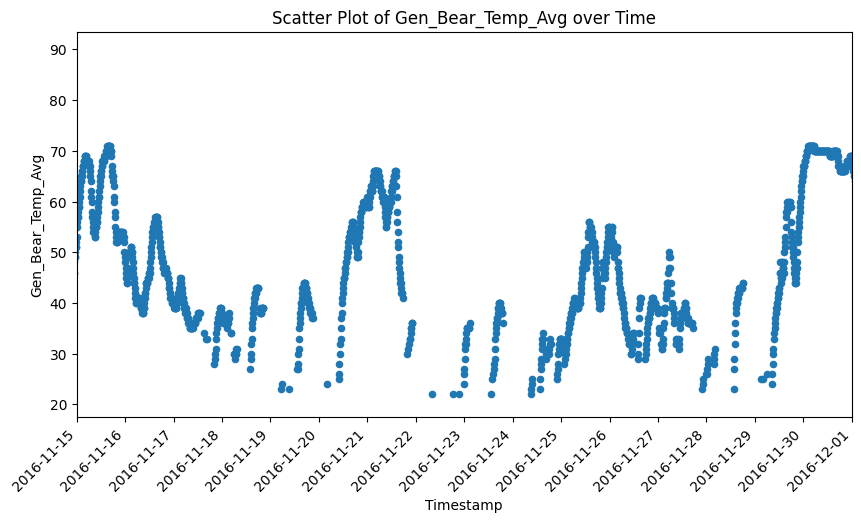

In [6]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


## Custom features

In [7]:
# creating data columns for the xgboost regressor

# Air density

# acceleration last x seconds

# Can we implement average speed for the last 30 minutes

# C_p?

# tip speed ratio

# Angle of blades

# Wind direction

# wind speed modified for distributed wind speed on diameter of blade

## Xgboost model:

In [8]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

# Step 2: Specify the feature columns and the target variable
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]  # Features
target_column = 'Gen_Bear_Temp_Avg'  # Target variable

# Step 3: Prepare the training data from merged_df
X_train = merged_df[feature_columns]  # Feature set for training
y_train = merged_df[target_column]   # Target variable for training

# Step 4: Prepare the prediction data from merged_df17
X_test = merged_df17[feature_columns]  # Feature set for predictions

# Step 5: Initialize the XGBoost model
model = XGBRegressor()  # Use XGBClassifier() if it's a classification task

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions on the merged_df17 dataset
predictions = model.predict(X_test)

# Step 8: Evaluate the model on merged_df (Optional)
"""# This evaluation is only for the training dataset, not merged_df17
if isinstance(y_train, pd.Series) and y_train.nunique() <= 2:
    # If the target variable has two unique values, treat it as a classification problem
    train_predictions = model.predict(X_train)
    accuracy = accuracy_score(y_train, train_predictions.round())
    print(f'Accuracy on Training Data: {accuracy:.2f}')
else:
    # If it's a regression problem, calculate the mean squared error
    train_predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, train_predictions)
    print(f'Mean Squared Error on Training Data: {mse:.2f}')"""

# Step 9: Store predictions in merged_df17
merged_df17["xgboost_pred_2017"] = predictions


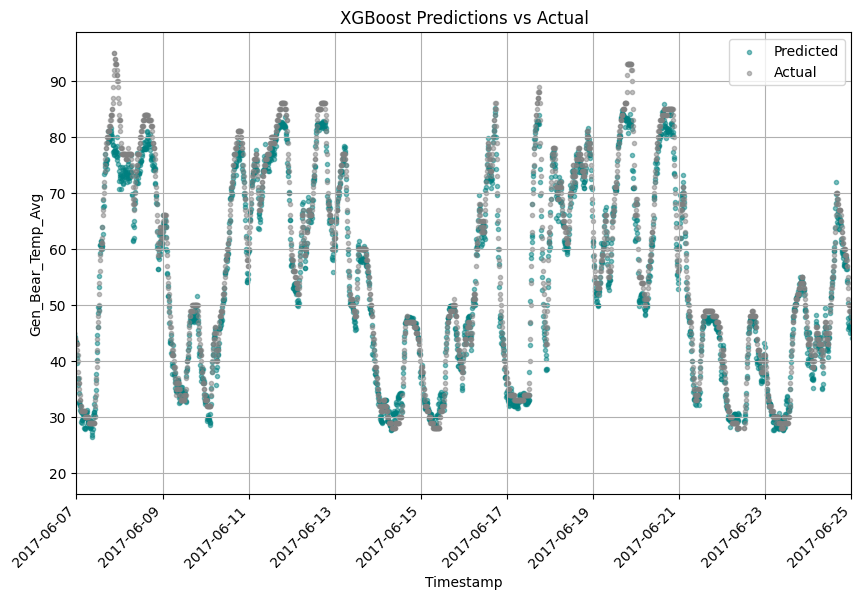

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(10, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions stored in 'cp_xgboost'
    c='teal', alpha=0.5, label='Predicted', marker="."
)

# Scatter plot for actual values (y_test)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='grey', alpha=0.5, label='Actual', marker=".", 
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for data (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel(target_column)
plt.legend()  # Show legend to distinguish between predicted and actual values
plt.grid(True)
plt.show()


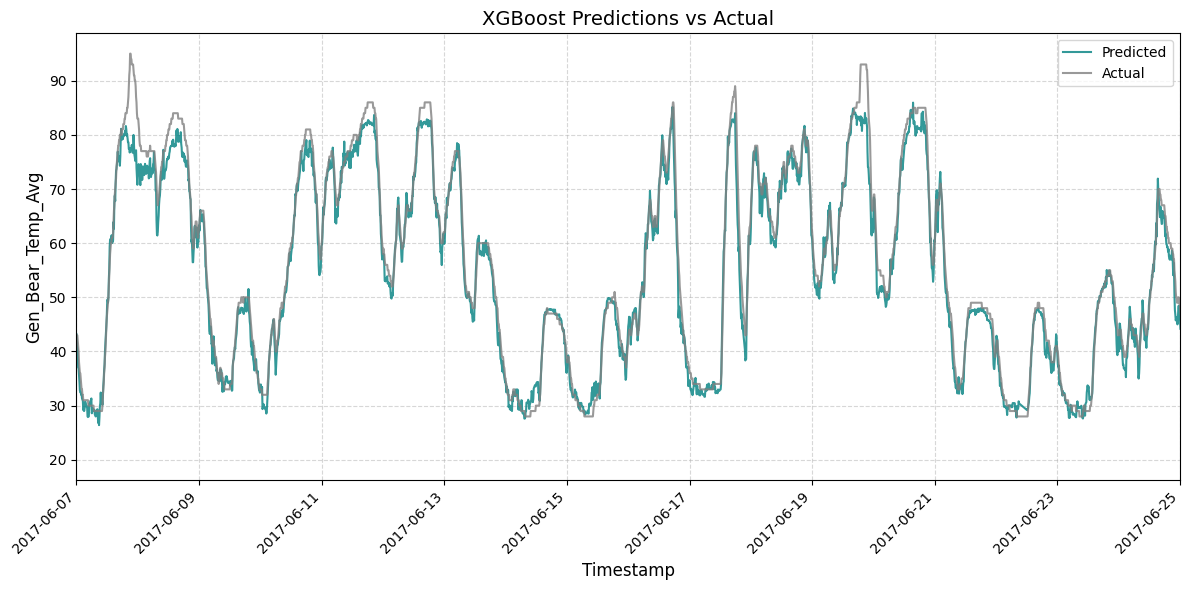

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='teal', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


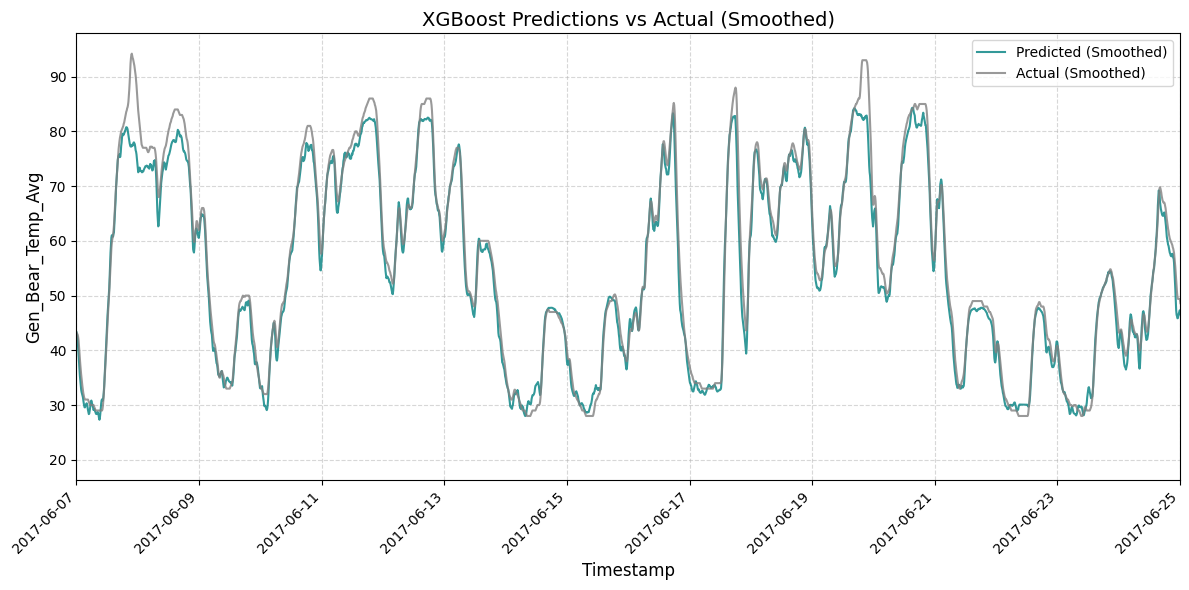

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

# Apply rolling average smoothing
rolling_window = 5  # Adjust window size as needed
merged_df_filtered17_sorted["xgboost_pred_2017_smoothed"] = (
    merged_df_filtered17_sorted["xgboost_pred_2017"].rolling(window=rolling_window).mean()
)
merged_df_filtered17_sorted["actual_smoothed"] = (
    merged_df_filtered17_sorted[target_column].rolling(window=rolling_window).mean()
)

# Plot
plt.figure(figsize=(12, 6))

# Line plot for smoothed predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017_smoothed"],  # Smoothed predictions
    color="teal",
    alpha=0.8,
    label="Predicted (Smoothed)",
    linestyle="-",
    linewidth=1.5,
)

# Line plot for smoothed actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["actual_smoothed"],  # Smoothed actual values
    color="grey",
    alpha=0.8,
    label="Actual (Smoothed)",
    linestyle="-",
    linewidth=1.5,
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime("2017-06-07"), pd.to_datetime("2017-06-25"))

# Title and labels
plt.title("XGBoost Predictions vs Actual (Smoothed)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


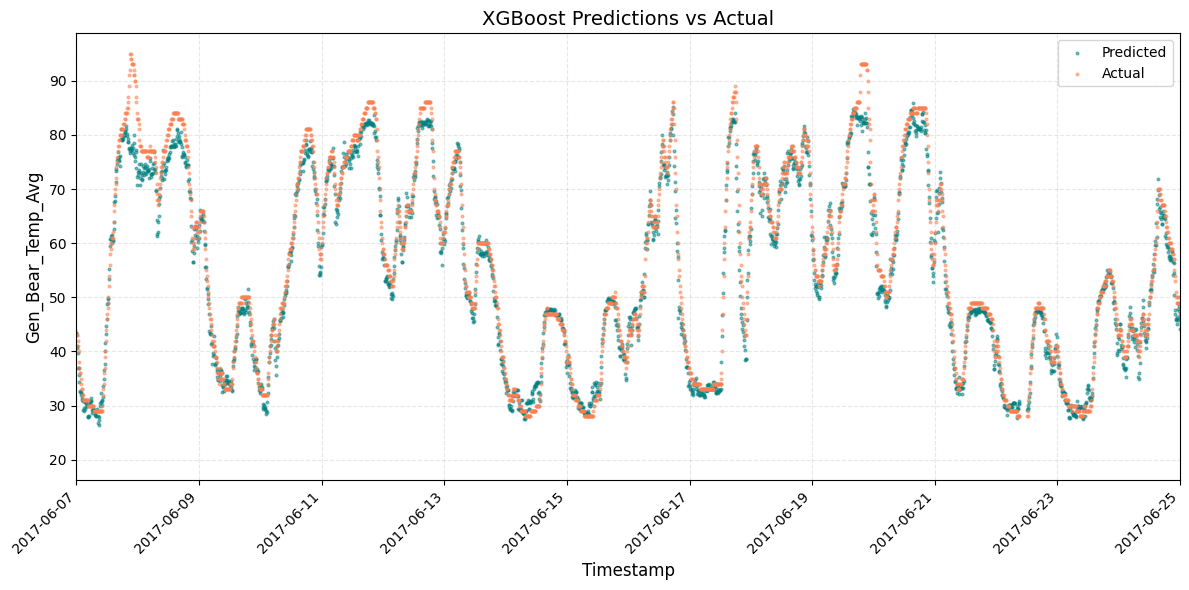

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    c='teal', alpha=0.5, label='Predicted', marker='.', s=15  # Adjusted size and transparency
)

# Scatter plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='coral', alpha=0.5, label='Actual', marker='.', s=15  # Different marker and transparency
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [13]:
merged_df_filtered17_sorted

Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   
...          ...                       ...          ...          ...   
729          T07 2017-12-31 23:10:00+00:00       1576.2       1253.8   
734          T07 2017-12-31 23:20:00+00:00       1577.7       1231.2   
29823        T07 2017-12-31 23:30:00+00:00       1282.8       1232.5   
738          T07 2017-12-31 23:40:00+00:00       1269.8       1230.8   
65839        T07 2017-12-31 23:50:00+00:00       1329.9       1193.0   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   
...            ...          ...                ...                  ...   
729         1387.4         79.7               39.0                   64   
734         1343.0         87.5               39.0                   63   
29823       1250.7          8.5               38.0                   63   
738         1250.2          6.9               38.0                   62   
65839       1257.6         18.9               38.0                   61   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  Anemometer2_Freq  \
87615                   58                   58  ...            0.0499   
37433                   58                   58  ...            0.0499   
54937                   58                   58  ...            0.0499   
87608                   58                   58  ...            0.0499   
19102                   58                   58  ...            0.0499   
...                    ...                  ...  ...               ...   
729                     64                   63  ...            0.0499   
734                     63                   63  ...            0.0499   
29823                   63                   62  ...            0.0499   
738                     62                   61  ...            0.0499   
65839                   61                   61  ...            0.0499   

       Anemometer2_Offset  Anemometer2_CorrGain  Anemometer2_CorrOffset  \
87615                0.24                     1                       0   
37433                0.24                     1                       0   
54937                0.24                     1                       0   
87608                0.24                     1                       0   
19102                0.24                     1                       0   
...                   ...                   ...                     ...   
729                  0.24                     1                       0   
734                  0.24                     1                       0   
29823                0.24                     1                       0   
738                  0.24                     1                       0   
65839                0.24                     1                       0   

       DistanceAirPress  AirRessureSensorZeroOffset  Anemometer1_Avg_Freq  \
87615                 0                         600                   156   
37433                 0                         600                   148   
54937                 0                         600                   151   
87608                 0                         600                   157   
19102                 0                         600              

In [14]:
merged_df_filtered17_sorted

Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   
...          ...                       ...          ...          ...   
729          T07 2017-12-31 23:10:00+00:00       1576.2       1253.8   
734          T07 2017-12-31 23:20:00+00:00       1577.7       1231.2   
29823        T07 2017-12-31 23:30:00+00:00       1282.8       1232.5   
738          T07 2017-12-31 23:40:00+00:00       1269.8       1230.8   
65839        T07 2017-12-31 23:50:00+00:00       1329.9       1193.0   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   
...            ...          ...                ...                  ...   
729         1387.4         79.7               39.0                   64   
734         1343.0         87.5               39.0                   63   
29823       1250.7          8.5               38.0                   63   
738         1250.2          6.9               38.0                   62   
65839       1257.6         18.9               38.0                   61   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  Anemometer2_Freq  \
87615                   58                   58  ...            0.0499   
37433                   58                   58  ...            0.0499   
54937                   58                   58  ...            0.0499   
87608                   58                   58  ...            0.0499   
19102                   58                   58  ...            0.0499   
...                    ...                  ...  ...               ...   
729                     64                   63  ...            0.0499   
734                     63                   63  ...            0.0499   
29823                   63                   62  ...            0.0499   
738                     62                   61  ...            0.0499   
65839                   61                   61  ...            0.0499   

       Anemometer2_Offset  Anemometer2_CorrGain  Anemometer2_CorrOffset  \
87615                0.24                     1                       0   
37433                0.24                     1                       0   
54937                0.24                     1                       0   
87608                0.24                     1                       0   
19102                0.24                     1                       0   
...                   ...                   ...                     ...   
729                  0.24                     1                       0   
734                  0.24                     1                       0   
29823                0.24                     1                       0   
738                  0.24                     1                       0   
65839                0.24                     1                       0   

       DistanceAirPress  AirRessureSensorZeroOffset  Anemometer1_Avg_Freq  \
87615                 0                         600                   156   
37433                 0                         600                   148   
54937                 0                         600                   151   
87608                 0                         600                   157   
19102                 0                         600              

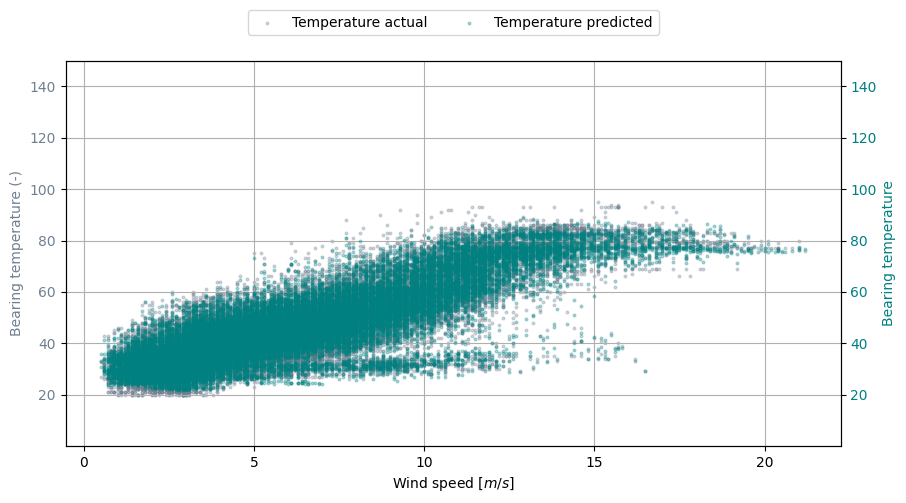

In [15]:
# Adjusted color scheme with burgundy and muted green
fig, ax1 = plt.subplots()  # Create a figure and axis

# Plotting the actual Cp values on the primary y-axis with burgundy
ax1.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], color='slategrey', label='Temperature actual', alpha=0.3, marker='.', s=15)
ax1.set_xlabel('Wind speed [$m/s$]')  # x-axis label
ax1.set_ylabel('Bearing temperature (-)', color='slategrey')  # Primary y-axis label color
ax1.tick_params(axis='y', labelcolor='slategrey')  # Primary y-axis label tick color
ax1.grid()
ax1.set_ylim(0.1, 150)  # Set y-limits for Cp values

# Create a secondary y-axis with a muted green color
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["xgboost_pred_2017"], color='teal', label='Temperature predicted', alpha=0.3, marker='.', s=15)  # Muted olive green color
ax2.set_ylabel('Bearing temperature', color='teal')  # Secondary y-axis label color
ax2.tick_params(axis='y', labelcolor='teal')  # Secondary y-axis label tick color
ax2.set_ylim(0.1, 150)

# Optional: Add legends for both y-axes with subtle colors
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), bbox_transform=ax1.transAxes, ncol=2)

# Show the plot
plt.show()

# Intervals:

In [16]:
# check units of the independent variables to make sure that interval is correctly chosen:
["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]
# Get a statistical summary for the other columns

windspeed_summary = merged_df_filtered17_sorted["Avg_Windspeed1"].describe()
nac_temp_summary = merged_df_filtered17_sorted["Nac_Temp_Avg"].describe()
humidity_summary = merged_df_filtered17_sorted["Avg_Humidity"].describe()
print(f"Avg Windspeed Summary:\n{windspeed_summary}")
print(f"Nac Temp Avg Summary:\n{nac_temp_summary}")
print(f"Avg Humidity Summary:\n{humidity_summary}")


Avg Windspeed Summary:
count    34581.000000
mean         6.257465
std          3.527416
min          0.000000
25%          3.600000
50%          5.600000
75%          8.400000
max         23.100000
Name: Avg_Windspeed1, dtype: float64
Nac Temp Avg Summary:
count    34582.000000
mean        31.666994
std          5.829491
min         17.000000
25%         28.000000
50%         32.000000
75%         36.000000
max         50.000000
Name: Nac_Temp_Avg, dtype: float64
Avg Humidity Summary:
count    34582.000000
mean        63.366694
std         17.430912
min         11.000000
25%         51.000000
50%         65.000000
75%         77.000000
max         99.000000
Name: Avg_Humidity, dtype: float64


In [17]:
humidity_interval = [-1,1]          # percentage? 
Gen_Phase1_Temp_interval = [-2,2]   # degrees
Gen_RPM_interval = [-1,1]           # RPM
Windspeed1_interval = [-1,1]        # m/s
Nac_Temp_interval = [-2,2]          # celcius

In [18]:
# Create and calculate 'max' columns using the average values and max of intervals
merged_df_filtered17_sorted["max_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(humidity_interval)
merged_df_filtered17_sorted["max_Gen_Phase1_Temp"] = merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + max(Gen_Phase1_Temp_interval)
merged_df_filtered17_sorted["max_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + max(Windspeed1_interval)
merged_df_filtered17_sorted["max_Nac_Temp"] = merged_df_filtered17_sorted["Nac_Temp_Avg"] + max(Nac_Temp_interval)

# Create and calculate 'min' columns using the average values and min of intervals
merged_df_filtered17_sorted["min_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + min(humidity_interval)
merged_df_filtered17_sorted["min_Gen_Phase1_Temp"] = merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + min(Gen_Phase1_Temp_interval)
merged_df_filtered17_sorted["min_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + min(Windspeed1_interval)
merged_df_filtered17_sorted["min_Nac_Temp"] = merged_df_filtered17_sorted["Nac_Temp_Avg"] + min(Nac_Temp_interval)


In [19]:
# Hva om vi lagde eit intervall for hvor utslitt utstyret er/ hvor lang tid til failure

In [20]:
print(model.get_booster().feature_names)

['Gen_Phase1_Temp_Avg', 'Gen_RPM_Avg', 'Avg_Windspeed1', 'Nac_Temp_Avg', 'Avg_Humidity']


In [21]:
import pandas as pd
import itertools

# Define the intervals
humidity_interval = [-2, 2]         # percentage %
Gen_Phase1_Temp_interval = [-2, 2]  # degrees Celcius
Gen_RPM_interval = [-1, 1]         # RPM
Windspeed1_interval = [-1, 1]      # m/s
Nac_Temp_interval = [-2, 2]        # Celsius

# Generate all 32 combinations of interval adjustments
combinations = list(itertools.product(
    humidity_interval,
    Gen_Phase1_Temp_interval,
    Gen_RPM_interval,
    Windspeed1_interval,
    Nac_Temp_interval
))

# Iterate through the 32 combinations
for idx, combo in enumerate(combinations):
    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo

    # Apply the combination adjustments to the time series
    X_test = pd.DataFrame({
        'Gen_Phase1_Temp_Avg': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        'Avg_Windspeed1': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        'Nac_Temp_Avg': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model for the entire time series
    predictions = model.predict(X_test)

    # Store predictions in the DataFrame
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

    print(f"Combination {idx+1}: Prediction completed for the entire time series.")

# Optionally, you can save or visualize the modified DataFrame
# For example:
# merged_df_filtered17_sorted.to_csv('predictions_with_combinations.csv', index=False)


Combination 1: Prediction completed for the entire time series.
Combination 2: Prediction completed for the entire time series.
Combination 3: Prediction completed for the entire time series.
Combination 4: Prediction completed for the entire time series.
Combination 5: Prediction completed for the entire time series.
Combination 6: Prediction completed for the entire time series.
Combination 7: Prediction completed for the entire time series.
Combination 8: Prediction completed for the entire time series.
Combination 9: Prediction completed for the entire time series.
Combination 10: Prediction completed for the entire time series.
Combination 11: Prediction completed for the entire time series.
Combination 12: Prediction completed for the entire time series.
Combination 13: Prediction completed for the entire time series.
Combination 14: Prediction completed for the entire time series.
Combination 15: Prediction completed for the entire time series.
Combination 16: Prediction complet

In [22]:
# Define the 'min' and 'max' columns
min_columns = ["min_Humidity", "min_Gen_Phase1_Temp", "min_Gen_RPM", "min_Windspeed1", "min_Nac_Temp"]
max_columns = ["max_Humidity", "max_Gen_Phase1_Temp", "max_Gen_RPM", "max_Windspeed1", "max_Nac_Temp"]

# Generate all 32 combinations of 'min' and 'max' features
combinations = []
for i in range(32):
    combination = []
    for j in range(5):
        if (i >> j) & 1:
            combination.append(max_columns[j])  # Use max for this feature
        else:
            combination.append(min_columns[j])  # Use min for this feature
    combinations.append(combination)

# Ensure the correct feature order for the model
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    # Prepare feature set for the current combination
    combination_features = merged_df_filtered17_sorted[comb].copy()
    
    # Rename columns to match the correct feature names and order
    combination_features.columns = feature_columns
    
    # Reorder columns to ensure proper order (optional, but ensures consistency)
    combination_features = combination_features[feature_columns]
    
    # Generate predictions for the current combination
    predictions = model.predict(combination_features)
    
    # Add predictions to the DataFrame as a new column
    merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions

# Check results
print(merged_df_filtered17_sorted.head())


      Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  \
87615                   58                   58  ...   
3743

In [23]:
# Ensure correct feature order for predictions
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]

# Verify the range of min and max columns
for col in min_columns + max_columns:
    print(f"{col} - Min: {merged_df_filtered17_sorted[col].min()}, Max: {merged_df_filtered17_sorted[col].max()}")

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    # Prepare feature set for the current combination
    combination_features = merged_df_filtered17_sorted[comb].copy()
    
    # Rename columns to match the correct feature names and order
    combination_features.columns = feature_columns
    
    # Ensure alignment of feature columns with the model's expectations
    combination_features = combination_features[feature_columns]
    
    # Debug: Check the range of features before prediction
    print(f"Combination {idx} - Feature ranges:")
    print(combination_features.describe())
    
    # Generate predictions
    predictions = model.predict(combination_features)
    
    # Add predictions to the DataFrame
    merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions



min_Humidity - Min: 10, Max: 98
min_Gen_Phase1_Temp - Min: 22, Max: 143
min_Gen_RPM - Min: -1.0, Max: 1682.8
min_Windspeed1 - Min: -1.0, Max: 22.1
min_Nac_Temp - Min: 15, Max: 48
max_Humidity - Min: 12, Max: 100
max_Gen_Phase1_Temp - Min: 26, Max: 147
max_Gen_RPM - Min: 1.0, Max: 1684.8
max_Windspeed1 - Min: 1.0, Max: 24.1
max_Nac_Temp - Min: 19, Max: 52
Combination 1 - Feature ranges:
       Gen_Phase1_Temp_Avg   Gen_RPM_Avg  Avg_Windspeed1  Nac_Temp_Avg  \
count         34582.000000  34582.000000    34582.000000  34581.000000   
mean             62.366694     66.326933     1066.409869      5.257465   
std              17.430912     29.825126      611.287551      3.527416   
min              10.000000     22.000000       -1.000000     -1.000000   
25%              50.000000     43.000000      282.000000      2.600000   
50%              64.000000     62.000000     1265.600000      4.600000   
75%              76.000000     80.000000     1602.500000      7.400000   
max              98

In [24]:
combinations

[['min_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'max_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'max_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'min_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'max_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'max_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'max_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'max_Windspeed1',
  'min_Nac_Temp'],
 ['min_Hum

In [25]:
"""import matplotlib.pyplot as plt

# Plot predictions for all 32 combinations with subplots
fig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations
axes = axes.flatten()  # Flatten the 2D grid for easy iteration

# Iterate through combinations
for idx, combo in enumerate(combinations):
    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo

    X_test = pd.DataFrame({
        'Gen_Phase1_Temp_Avg': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        'Avg_Windspeed1': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        'Nac_Temp_Avg': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model
    predictions = model.predict(X_test)
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

    ax = axes[idx]
    ax.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],
               color='slategrey', alpha=0.3, marker='.', s=15, label='Temperature actual')
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], predictions,
                color='teal', alpha=0.3, marker='.', s=15, label=f'Pred_comb_{idx+1}')

    ax.set_title(f'Combination {idx+1}')
    ax.set_xlabel('Wind Speed [$m/s$]')
    ax.set_ylabel('Bearing Temperature (-)', color='slategrey')
    ax.tick_params(axis='y', labelcolor='slategrey')
    ax2.set_ylabel('Predictions', color='teal')

# Show the overall plot
plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\n\n# Plot predictions for all 32 combinations with subplots\nfig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations\naxes = axes.flatten()  # Flatten the 2D grid for easy iteration\n\n# Iterate through combinations\nfor idx, combo in enumerate(combinations):\n    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo\n\n    X_test = pd.DataFrame({\n        \'Gen_Phase1_Temp_Avg\': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,\n        \'Gen_RPM_Avg\': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,\n        \'Avg_Windspeed1\': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,\n        \'Nac_Temp_Avg\': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,\n        \'Avg_Humidity\': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val\n    })\n\n    # Predict with the model\n    predictions = model.predict(X_test)\n    merged_df_filtered1

In [26]:

print(merged_df_filtered17_sorted.iloc[0])


Turbine_ID                                         T07
Timestamp                    2017-01-01 00:00:00+00:00
Gen_RPM_Max                                     1513.4
Gen_RPM_Min                                     1255.3
Gen_RPM_Avg                                     1336.5
                                       ...            
combination_28_prediction                    46.956501
combination_29_prediction                    47.429569
combination_30_prediction                    46.956501
combination_31_prediction                    47.429569
combination_32_prediction                    46.956501
Name: 87615, Length: 198, dtype: object


In [27]:
"""print(merged_df_filtered17_sorted["humidity_val"]) # View the first 5 rows"""


'print(merged_df_filtered17_sorted["humidity_val"]) # View the first 5 rows'

In [28]:
# Display the first 5 rows of the DataFrame
print(merged_df_filtered17_sorted.head())


      Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  \
87615                   58                   58  ...   
3743

In [29]:
combinations

[['min_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'max_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'max_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'min_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'max_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'max_Gen_Phase1_Temp',
  'max_Gen_RPM',
  'min_Windspeed1',
  'min_Nac_Temp'],
 ['min_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'max_Windspeed1',
  'min_Nac_Temp'],
 ['max_Humidity',
  'min_Gen_Phase1_Temp',
  'min_Gen_RPM',
  'max_Windspeed1',
  'min_Nac_Temp'],
 ['min_Hum

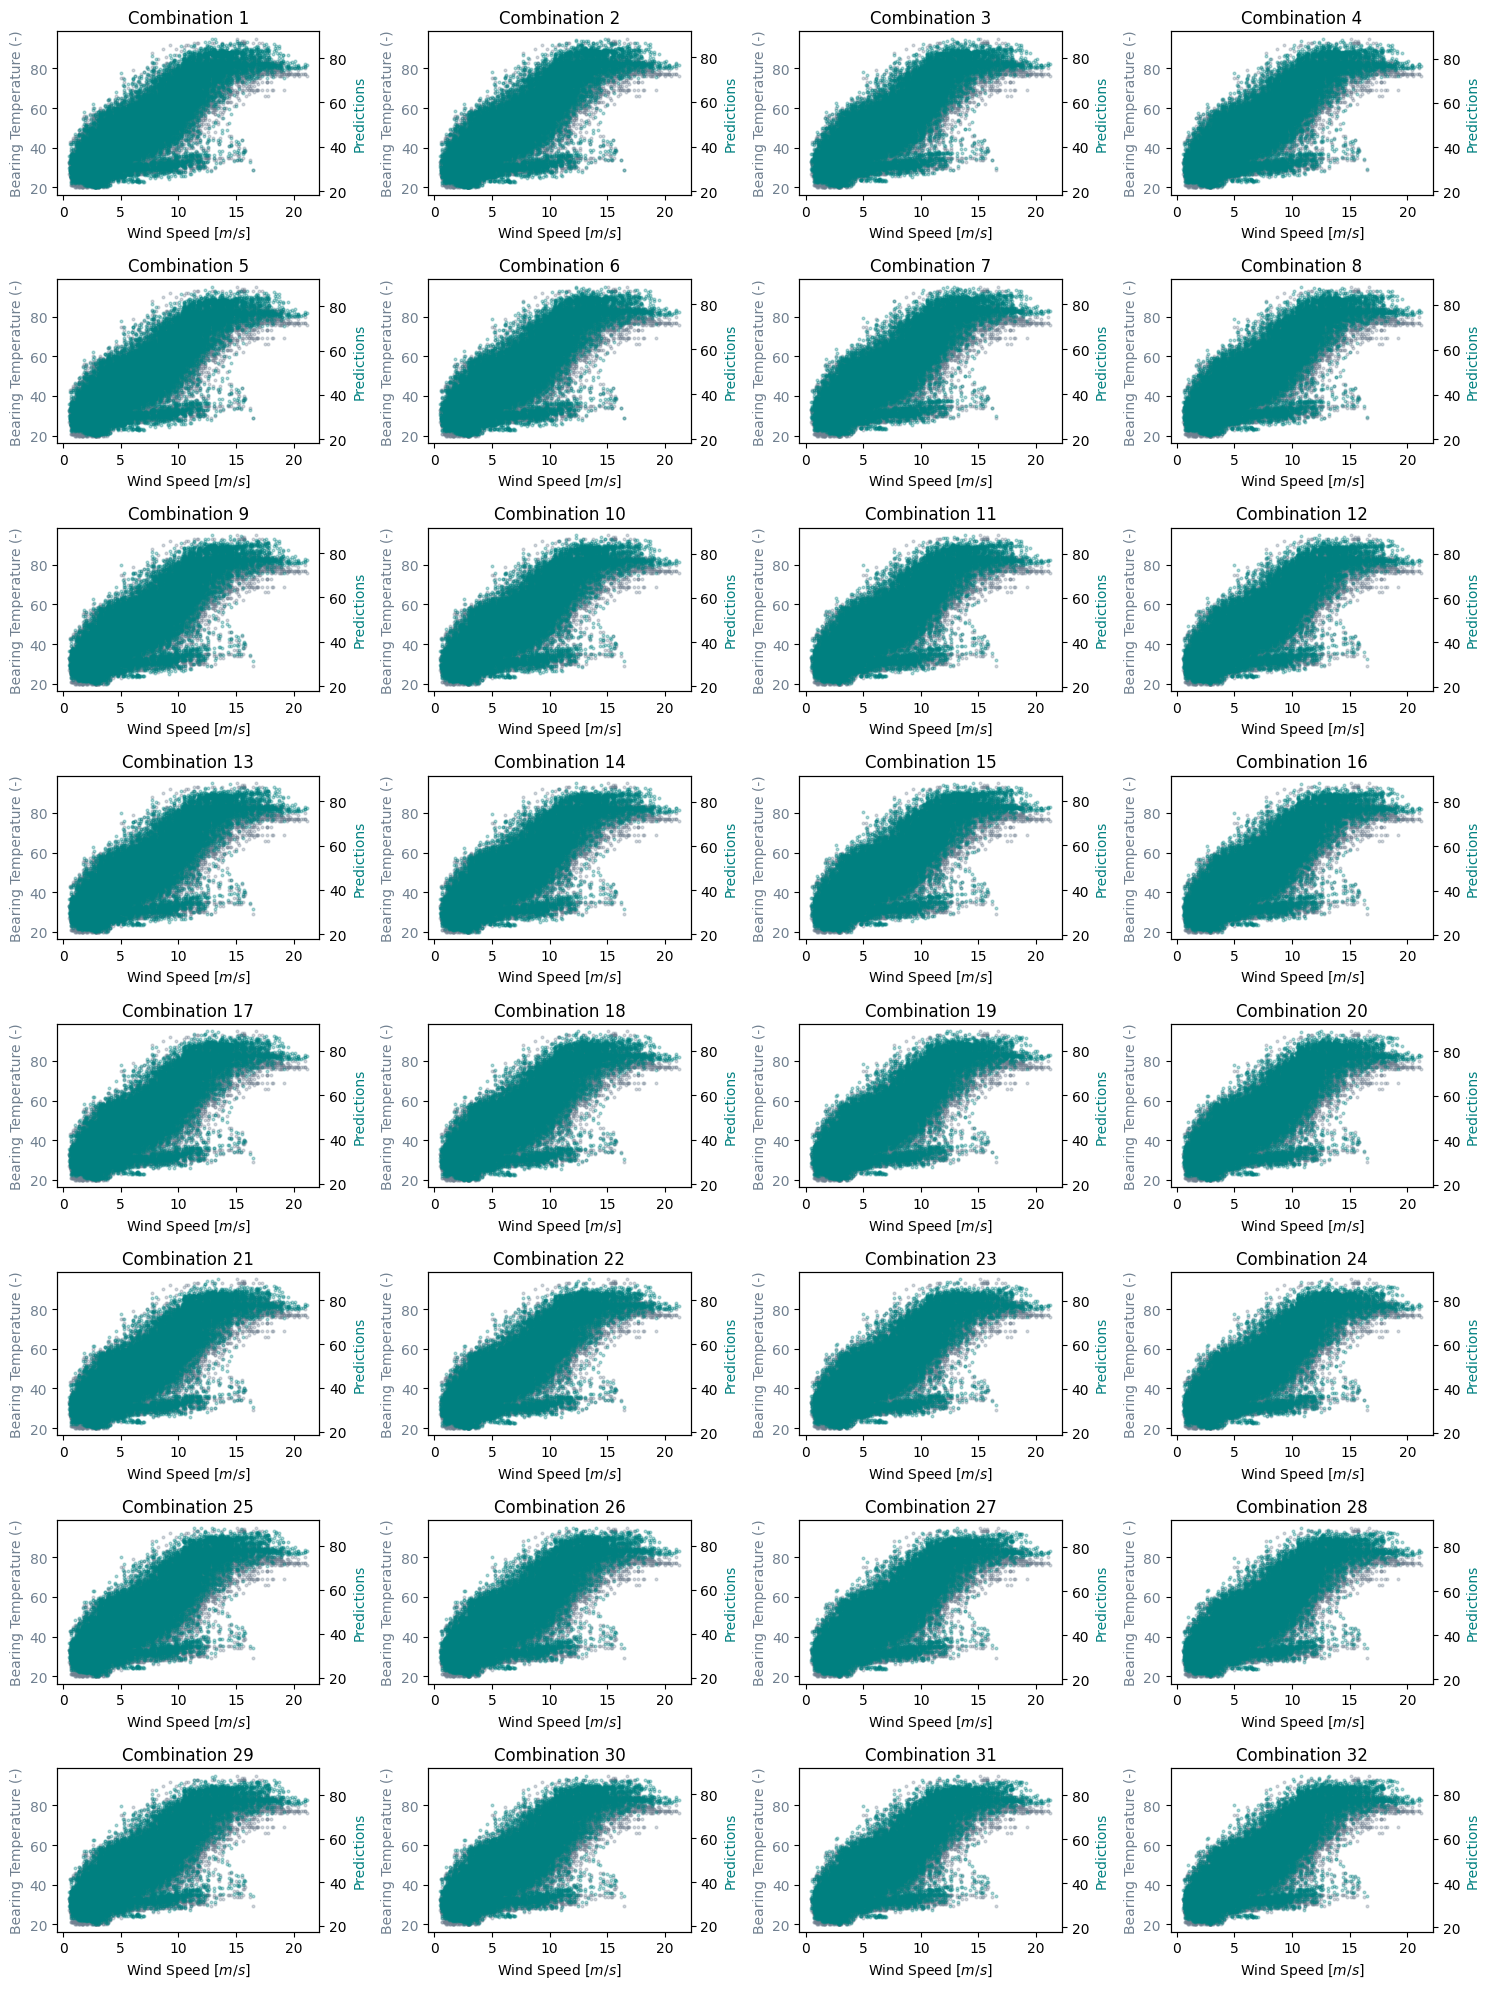

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure relevant columns are numeric
merged_df_filtered17_sorted["Amb_WindSpeed_Avg"] = pd.to_numeric(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], errors="coerce")
merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] = pd.to_numeric(merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], errors="coerce")

# Plot predictions for all 32 combinations with subplots
fig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations
axes = axes.flatten()  # Flatten the 2D grid for easy iteration

# Iterate through combinations
for idx, combo in enumerate(combinations):
    # Prepare values from combinations
    humidity_val = 0 if 'min_Humidity' in combo else 1
    Gen_Phase1_Temp_val = 0 if 'min_Gen_Phase1_Temp' in combo else 1
    Gen_RPM_val = 0 if 'min_Gen_RPM' in combo else 1
    Windspeed_val = 0 if 'min_Windspeed1' in combo else 1
    Nac_Temp_val = 0 if 'min_Nac_Temp' in combo else 1

    # Create a test DataFrame
    X_test = pd.DataFrame({
        "Gen_Phase1_Temp_Avg": merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        "Gen_RPM_Avg": merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        "Avg_Windspeed1": merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        "Nac_Temp_Avg": merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        "Avg_Humidity": merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model
    predictions = model.predict(X_test)
    merged_df_filtered17_sorted[f"pred_comb_{idx+1}"] = predictions

    # Scatter plots
    ax = axes[idx]
    ax.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],
               color="slategrey", alpha=0.3, marker=".", s=15, label="Temperature actual")
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], predictions,
                color="teal", alpha=0.3, marker=".", s=15, label=f"Pred_comb_{idx+1}")

    # Set titles and labels
    ax.set_title(f"Combination {idx+1}")
    ax.set_xlabel("Wind Speed [$m/s$]")
    ax.set_ylabel("Bearing Temperature (-)", color="slategrey")
    ax.tick_params(axis="y", labelcolor="slategrey")
    ax2.set_ylabel("Predictions", color="teal")

# Show the overall plot
plt.tight_layout()
plt.show()


In [31]:
"""import matplotlib.pyplot as plt
import pandas as pd

# Identify prediction columns (e.g., columns starting with 'pred_comb_')
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure numeric types for prediction columns
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted['row_min'] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted['row_max'] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Scatter plot of min and max predictions
plt.figure(figsize=(10, 6))

# Scatter for min predictions
plt.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
            merged_df_filtered17_sorted["row_min"], 
            color='blue', alpha=0.5, label='Row Min Predictions', s=15)

# Scatter for max predictions
plt.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
            merged_df_filtered17_sorted["row_max"], 
            color='red', alpha=0.5, label='Row Max Predictions', s=15)

# Plot settings
plt.xlabel('Wind Speed [$m/s$]')
plt.ylabel('Predictions')
plt.title('Row-wise Min and Max Predictions Across Combinations')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
"""

'import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Identify prediction columns (e.g., columns starting with \'pred_comb_\')\nprediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith(\'pred_comb_\')]\n\n# Ensure numeric types for prediction columns\nmerged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors=\'coerce\')\n\n# Compute row-wise min and max for prediction columns\nmerged_df_filtered17_sorted[\'row_min\'] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)\nmerged_df_filtered17_sorted[\'row_max\'] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)\n\n# Scatter plot of min and max predictions\nplt.figure(figsize=(10, 6))\n\n# Scatter for min predictions\nplt.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], \n            merged_df_filtered17_sorted["row_min"], \n            color=\'blue\', alpha=0.5, label=\'Row Min Predictions\', s=15)\n\n#

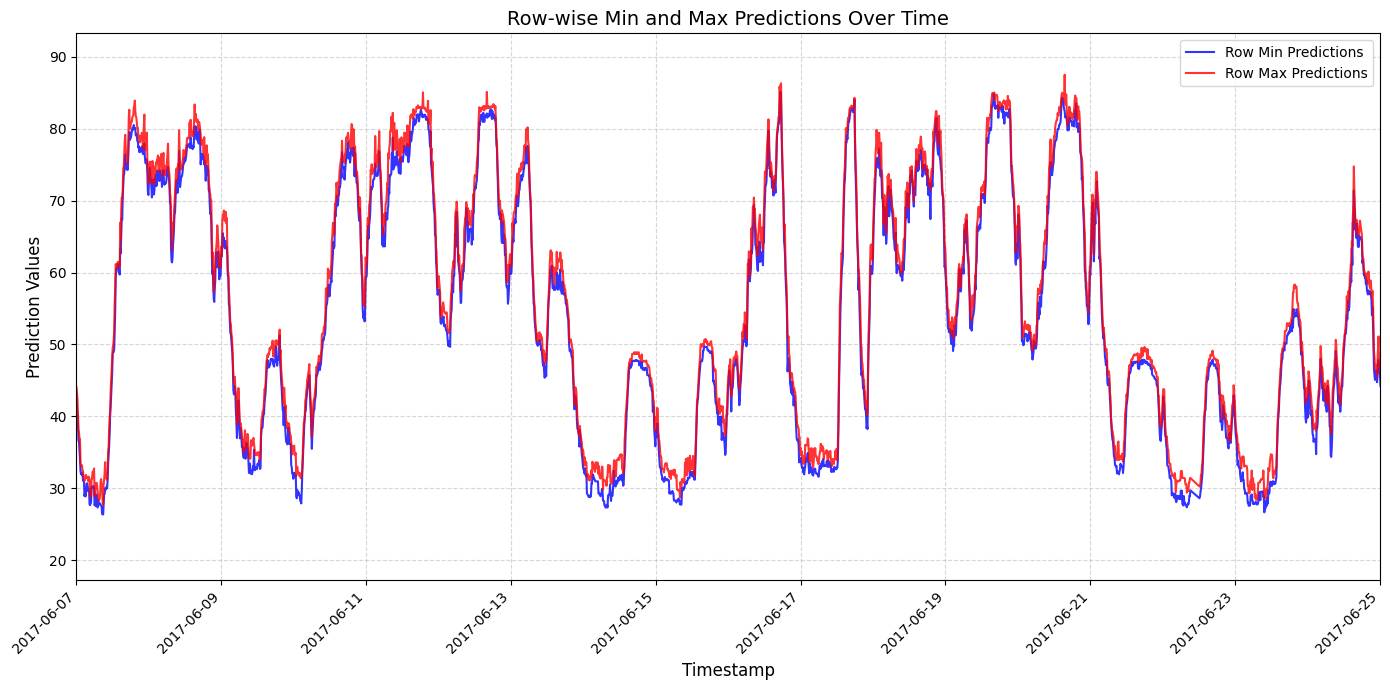

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot min and max predictions over time
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Row-wise Min and Max Predictions Over Time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Prediction Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


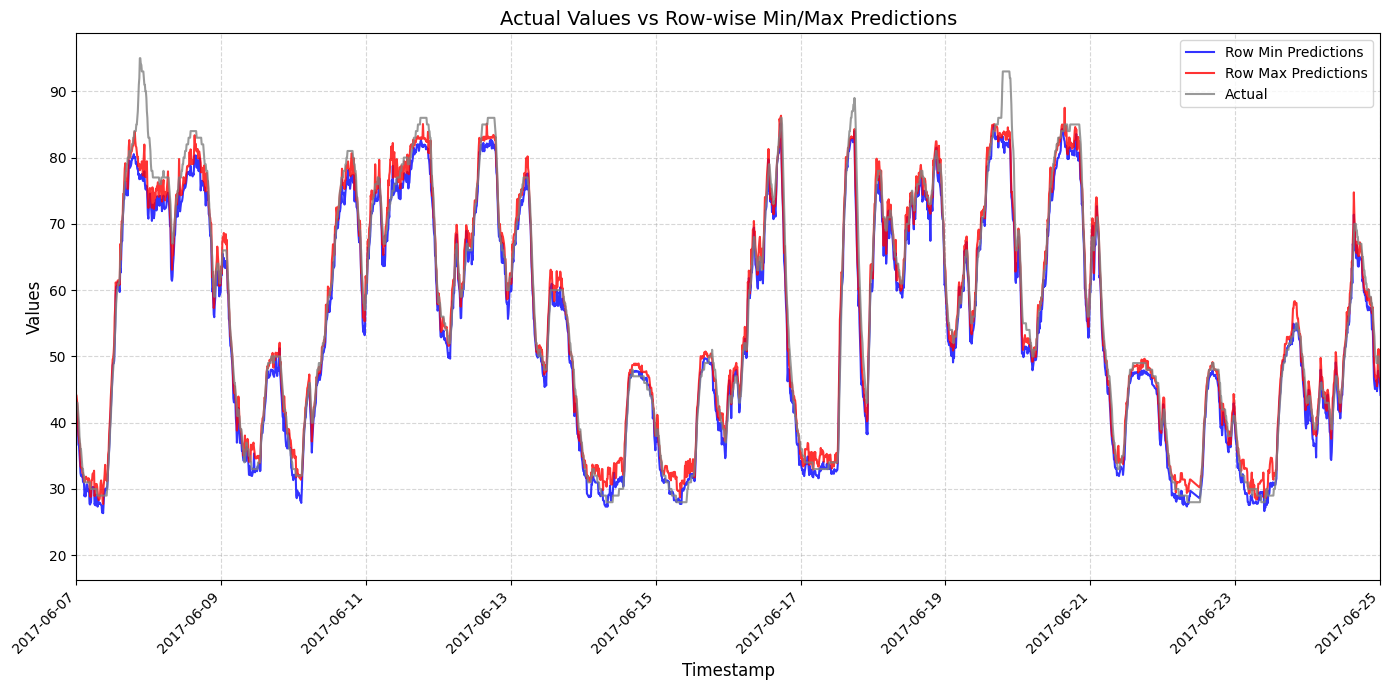

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp for proper chronological plotting
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Define interval for x-axis if needed (adjust start and end dates)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Actual Values vs Row-wise Min/Max Predictions", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Values", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


Gaussian filter to smooth the target colum (actual temperature)

In [34]:
from scipy.ndimage import gaussian_filter1d

"""# Apply Gaussian filter
sigma = 1  # Standard deviation for Gaussian kernel (adjust as needed)

merged_df_filtered17_sorted[target_column] = gaussian_filter1d(
    merged_df_filtered17_sorted[target_column], sigma=sigma
)

"""

'# Apply Gaussian filter\nsigma = 1  # Standard deviation for Gaussian kernel (adjust as needed)\n\nmerged_df_filtered17_sorted[target_column] = gaussian_filter1d(\n    merged_df_filtered17_sorted[target_column], sigma=sigma\n)\n\n'

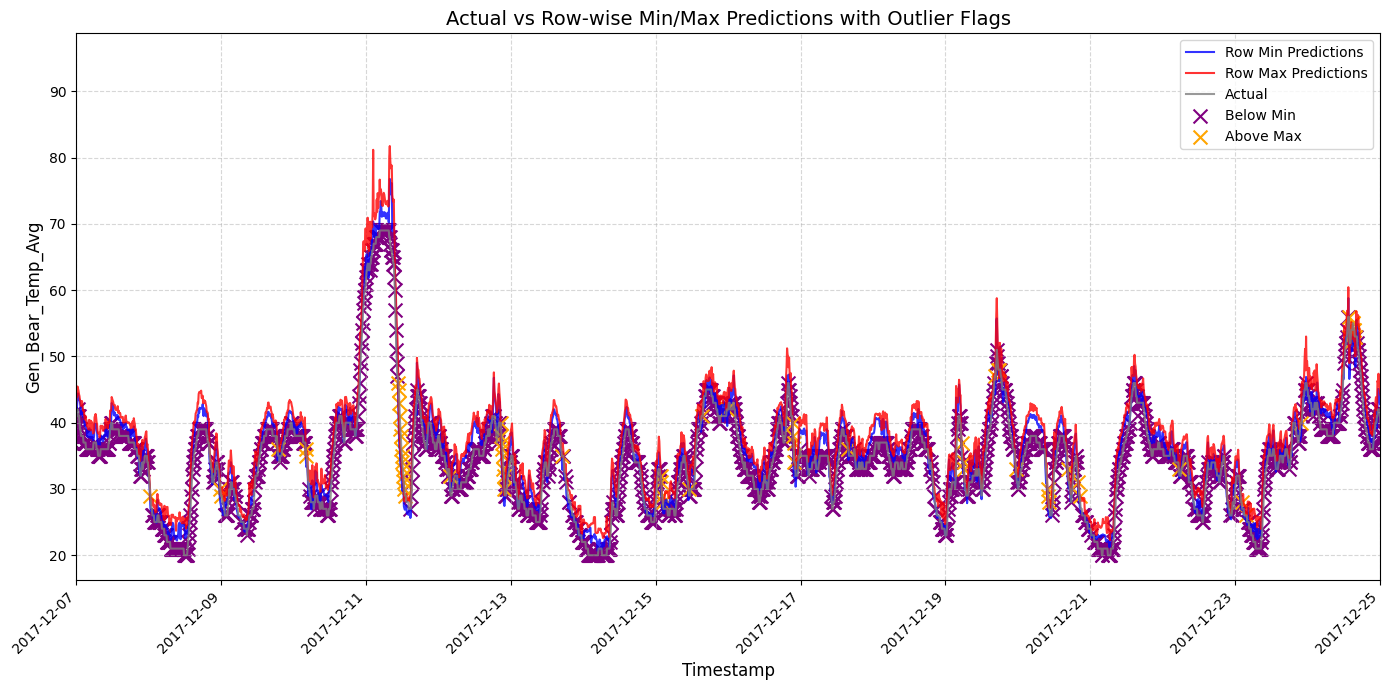

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)



# Flag where actual values are outside the row-wise min and max
merged_df_filtered17_sorted["below_min"] = (merged_df_filtered17_sorted[target_column] < merged_df_filtered17_sorted["row_min"]).astype(int)
merged_df_filtered17_sorted["above_max"] = (merged_df_filtered17_sorted[target_column] > merged_df_filtered17_sorted["row_max"]).astype(int)



# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"], 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"], 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label='Below Min'
)

# Scatter points where actual is above row_max
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label='Above Max'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Outlier Flags", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


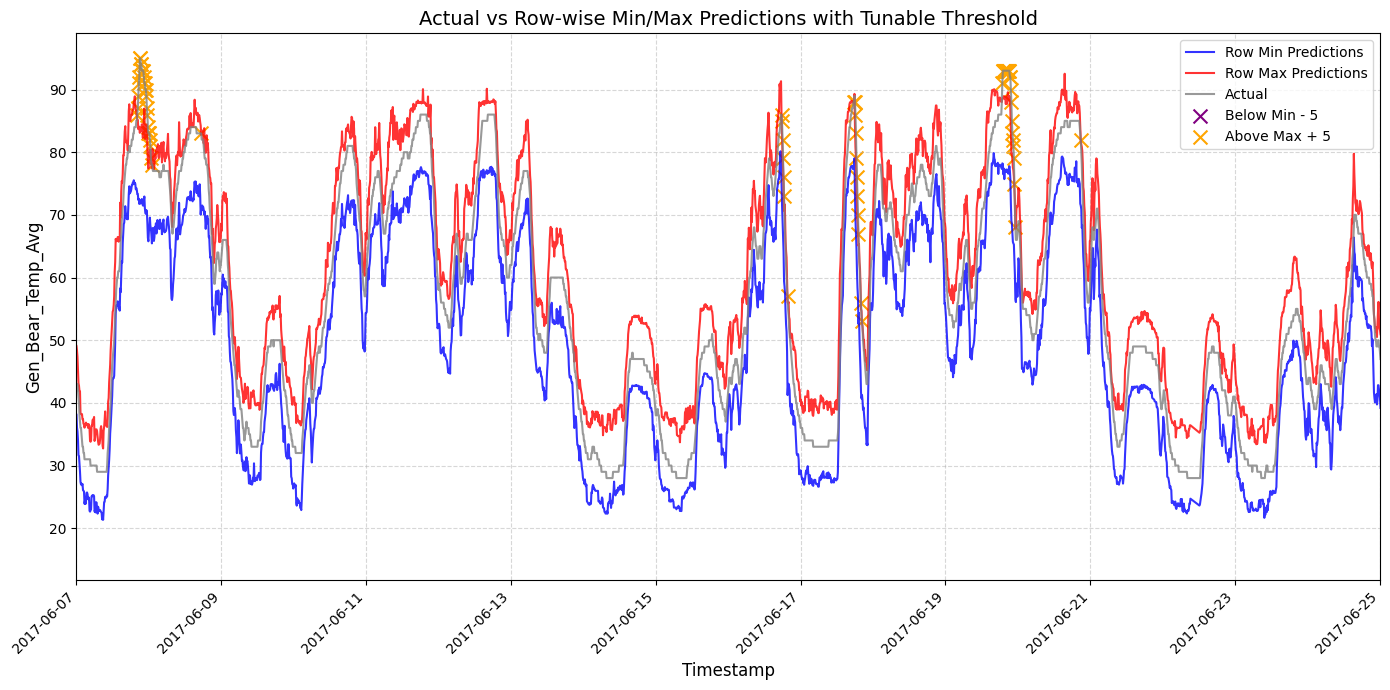

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 5  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)


##### Inserted filtering ######

"""sigma = 2  # Standard deviation for Gaussian kernel (adjust as needed)
merged_df_filtered17_sorted["row_min"] = gaussian_filter1d(
    merged_df_filtered17_sorted["row_min"], sigma=sigma
)
merged_df_filtered17_sorted["row_max"] = gaussian_filter1d(
    merged_df_filtered17_sorted["row_max"], sigma=sigma
)
"""
##### filtering finished ######

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-threshold, 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+threshold, 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


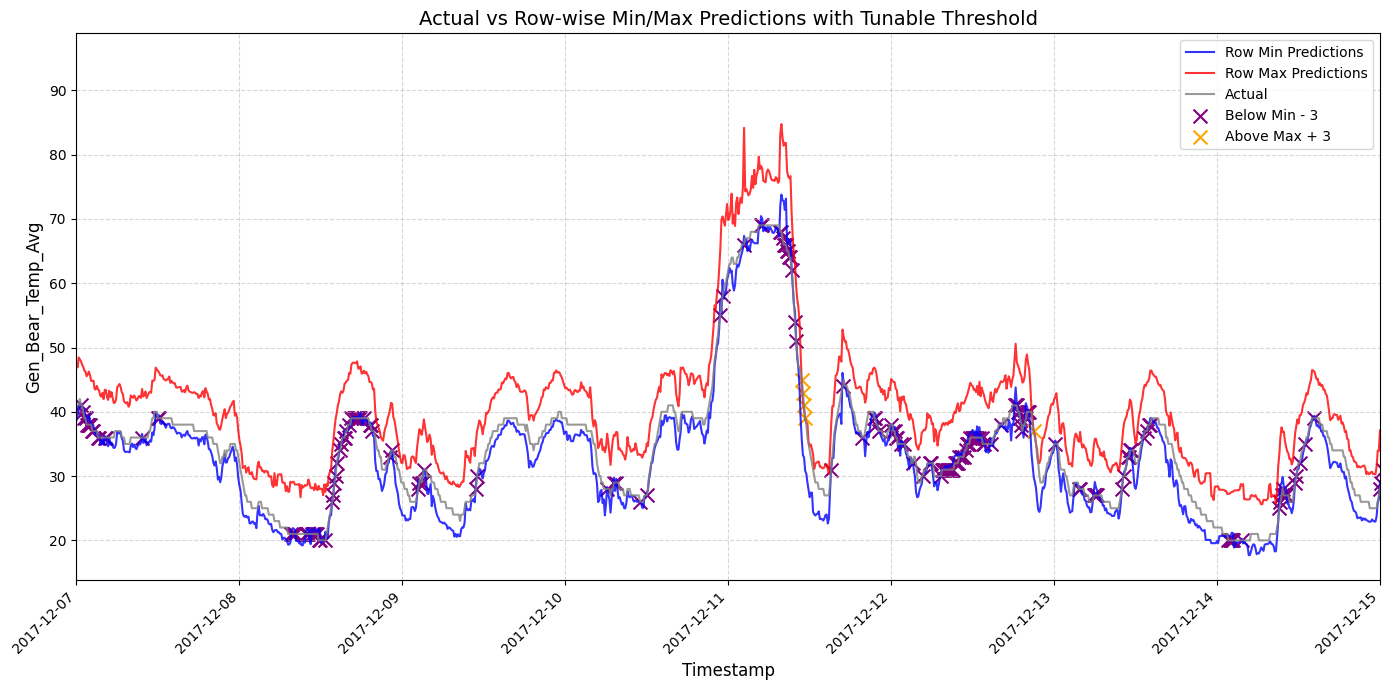

In [37]:
# Checking other dates of the year when the turbine generator is in healthy condition:

import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 3  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted[target_column] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted[target_column] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-threshold, 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+ threshold, 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted[target_column],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted[target_column][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-15'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Tunable Threshold", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


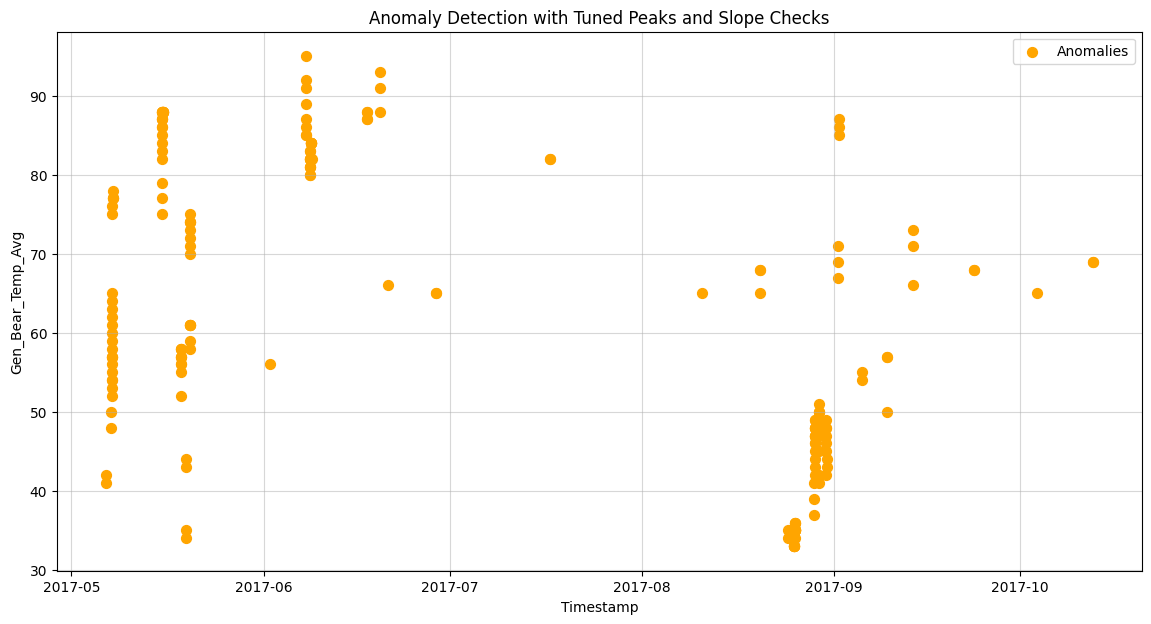

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Parameters
buffer = 3  # Additional buffer above row_max to consider as a high point
check_slope_window = 1  # Number of rows (Z) to check slope before initiating anomalies
consecutive_steps = 1  # Number of positive slope steps to confirm peak anomalies
max_length = 2 # Maximum sequence length for anomalies
lower_limit = 10  # Lower operational limit
upper_limit = 100  # Upper operational limit

# Flags to control slope dependency checks
check_slope = False  # Set to False to deactivate slope checks (checks the initial slope of Z)
check_ongoing_slope = False  # Set to False to deactivate ongoing slope checks (cancels if an ongoing negative slope is detected)
final_slope_check = False  # Set to False to deactivate final slope check throw (checks if there are only negative slopes and throws away the anomaly if it is only negative)
final_overall_slope_check = True  # Set to True to enable final overall slope check (throws away anomaly if the overall slope is negative)
max_consecutive_negative_slopes = 1  # Max consecutive negative slopes before discarding anomaly

# Calculate the difference from row_max
merged_df_filtered17_sorted["difference"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] - (merged_df_filtered17_sorted["row_max"] + buffer)
)

# Initialize anomaly flag
merged_df_filtered17_sorted["anomaly_flag"] = 0  # New column for marking anomalies

# Loop through the data
for i in range(len(merged_df_filtered17_sorted)):
    if i >= check_slope_window:
        # Check slope in the last Z rows if slope checks are enabled
        if check_slope:
            recent_temps = merged_df_filtered17_sorted.iloc[i - check_slope_window : i]["Gen_Bear_Temp_Avg"].values
            slope = np.polyfit(range(check_slope_window), recent_temps, 1)[0]  # Fit linear slope

            # Proceed only if slope is positive
            if slope <= 0:
                continue  # Skip this row if slope is non-positive
        
        # Start anomaly detection if current difference > 0
        if merged_df_filtered17_sorted.iloc[i]["difference"] > 0:
            temp_list = []
            start_idx = i
            slopes_between_points = []  # List to store slopes between points
            consecutive_negative_slopes = 0  # Counter for consecutive negative slopes

            # Begin sequence recording
            while i < len(merged_df_filtered17_sorted):
                current_temp = merged_df_filtered17_sorted.iloc[i]["Gen_Bear_Temp_Avg"]
                temp_list.append(current_temp)

                # Check ongoing slope if enabled
                if len(temp_list) > 1 and check_ongoing_slope:
                    ongoing_slope = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    if ongoing_slope <= 0:
                        break  # Break if slope is not positive

                # Validate sequence with buffer and slope
                if (
                    merged_df_filtered17_sorted.iloc[i]["difference"] <= 0
                    or len(temp_list) > max_length
                ):
                    break

                # Store slope between consecutive points if there are enough points
                if len(temp_list) > 1:
                    slope_between_points = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    slopes_between_points.append(slope_between_points)

                    # Count consecutive negative slopes
                    if slope_between_points <= 0:
                        consecutive_negative_slopes += 1
                    else:
                        consecutive_negative_slopes = 0  # Reset counter if positive slope is found

                i += 1

            # Final anomaly validation with slope check if enabled
            if len(temp_list) >= consecutive_steps:
                avg_temp = np.mean(temp_list)

                # If the final slope check is enabled, check if consecutive negative slopes exceed threshold
                if final_slope_check and consecutive_negative_slopes >= max_consecutive_negative_slopes:
                    continue  # Discard if too many consecutive negative slopes

                # Final overall slope check (if enabled)
                if final_overall_slope_check:
                    overall_slope = np.polyfit(range(len(temp_list)), temp_list, 1)[0]
                    if overall_slope <= 0:
                        continue  # Discard anomaly if overall slope is negative

                # Validate anomaly with temperature and slope conditions
                if avg_temp > lower_limit and avg_temp < upper_limit:
                    merged_df_filtered17_sorted.loc[
                        merged_df_filtered17_sorted.index[start_idx:i], "anomaly_flag"
                    ] = 1

# Visualization
plt.figure(figsize=(14, 7))

# Scatter anomalies
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="orange",
    label="Anomalies",
    s=50,
)

plt.legend()
plt.title("Anomaly Detection with Tuned Peaks and Slope Checks")
plt.xlabel("Timestamp")
plt.ylabel("Gen_Bear_Temp_Avg")
plt.grid(alpha=0.5)
plt.show()

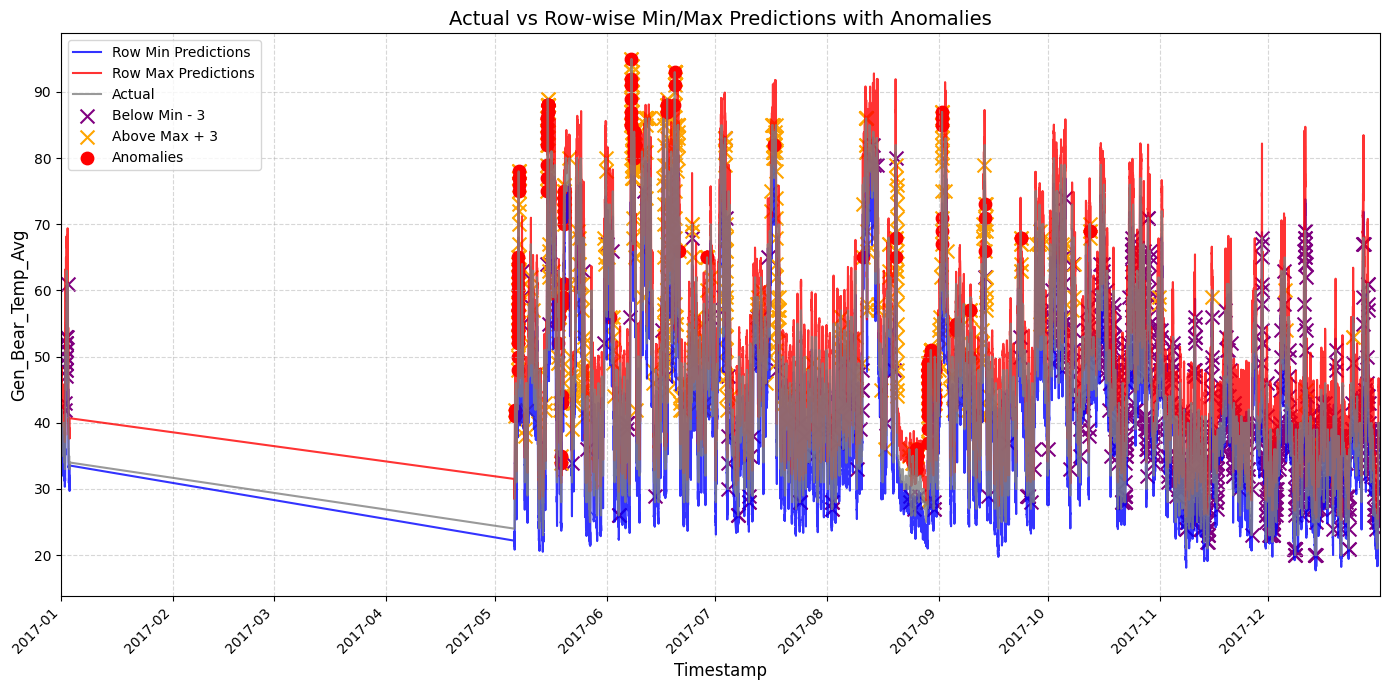

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 3  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-threshold, 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+threshold, 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(merged_df_filtered17_sorted["Timestamp"].min(), merged_df_filtered17_sorted["Timestamp"].max())

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


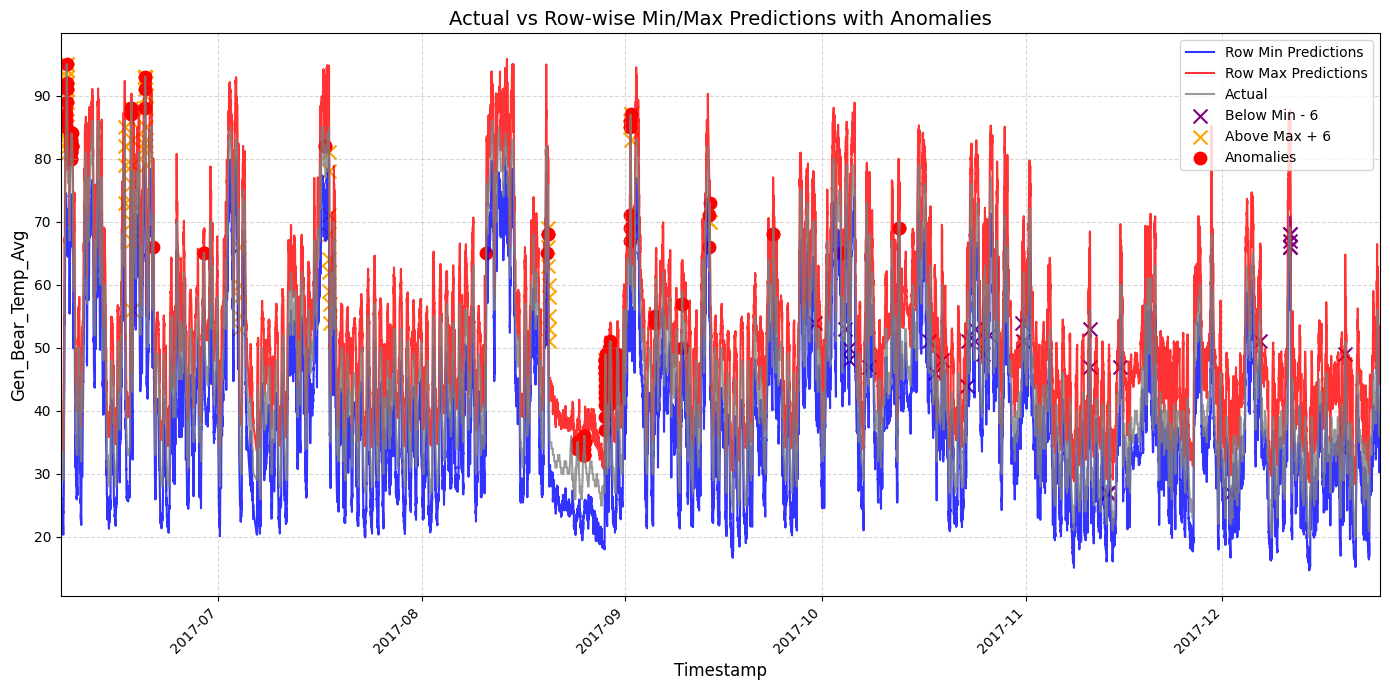

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 6  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-threshold, 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+threshold, 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjusted for the timeframe from the plot you provided)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-12-25'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


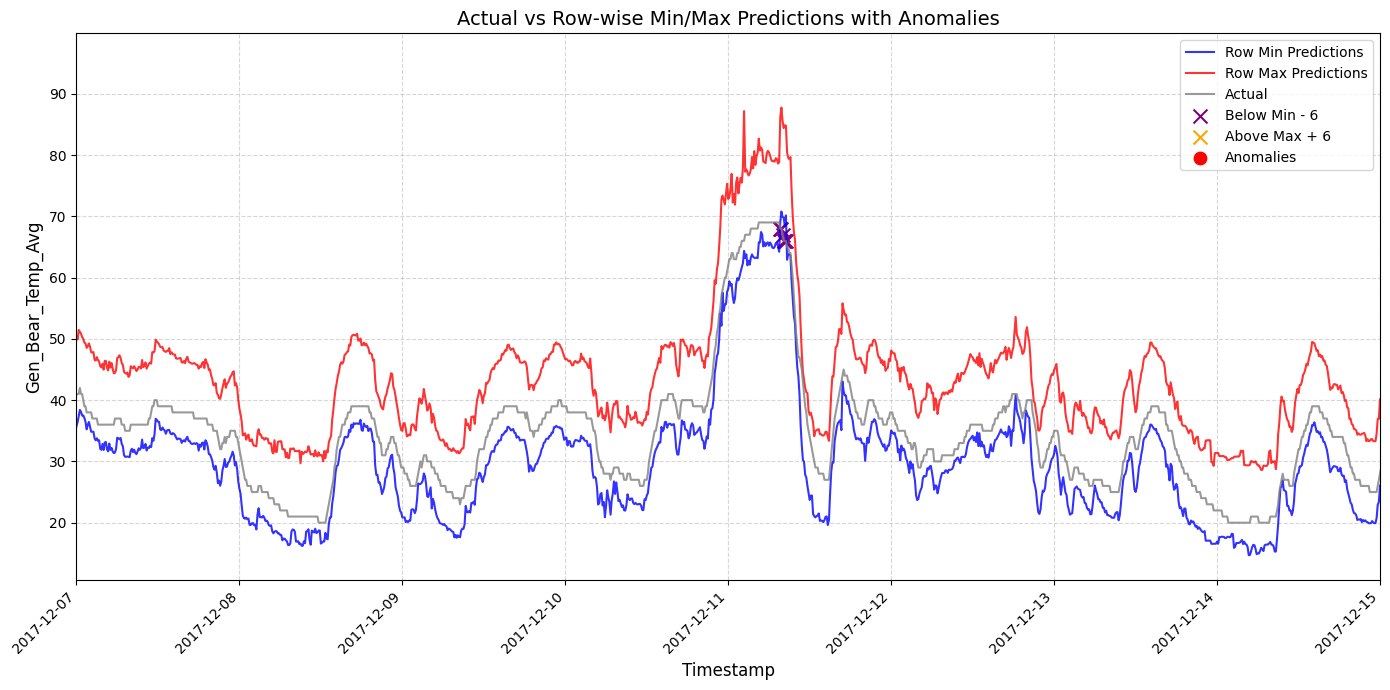

In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df_filtered17_sorted["Timestamp"] = pd.to_datetime(merged_df_filtered17_sorted["Timestamp"])

# Sort the DataFrame by Timestamp
merged_df_filtered17_sorted = merged_df_filtered17_sorted.sort_values(by="Timestamp")

# Define tunable threshold
threshold = 6  # Change this value as needed (e.g., 2 means >2 above max or <-2 below min)

# Identify prediction columns
prediction_columns = [col for col in merged_df_filtered17_sorted.columns if col.startswith('pred_comb_')]

# Ensure prediction columns are numeric
merged_df_filtered17_sorted[prediction_columns] = merged_df_filtered17_sorted[prediction_columns].apply(pd.to_numeric, errors='coerce')

# Compute row-wise min and max for prediction columns
merged_df_filtered17_sorted["row_min"] = merged_df_filtered17_sorted[prediction_columns].min(axis=1)
merged_df_filtered17_sorted["row_max"] = merged_df_filtered17_sorted[prediction_columns].max(axis=1)

# Flag where actual values are outside the row-wise min and max with a threshold
merged_df_filtered17_sorted["below_min"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] < (merged_df_filtered17_sorted["row_min"] - threshold)
).astype(int)
merged_df_filtered17_sorted["above_max"] = (
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"] > (merged_df_filtered17_sorted["row_max"] + threshold)
).astype(int)

# Plot
plt.figure(figsize=(14, 7))

# Line plot for row-wise minimum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_min"]-threshold, 
    color='blue', alpha=0.8, label='Row Min Predictions', linewidth=1.5
)

# Line plot for row-wise maximum predictions
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"]+threshold, 
    color='red', alpha=0.8, label='Row Max Predictions', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],  
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Scatter points where actual is below row_min - threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["below_min"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["below_min"] == 1],
    color='purple', marker='x', s=100, label=f'Below Min - {threshold}'
)

# Scatter points where actual is above row_max + threshold
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["above_max"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["above_max"] == 1],
    color='orange', marker='x', s=100, label=f'Above Max + {threshold}'
)

# Highlight anomalies (from the anomaly detection step you have)
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted["anomaly_flag"] == 1]
plt.scatter(
    anomalies["Timestamp"],
    anomalies["Gen_Bear_Temp_Avg"],
    color="red",  # Anomalies in red
    label="Anomalies",
    s=80,
    marker='o'  # Circle marker for anomalies
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjusted for the timeframe from the plot you provided)
plt.xlim(pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-15'))

# Title and labels
plt.title("Actual vs Row-wise Min/Max Predictions with Anomalies", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


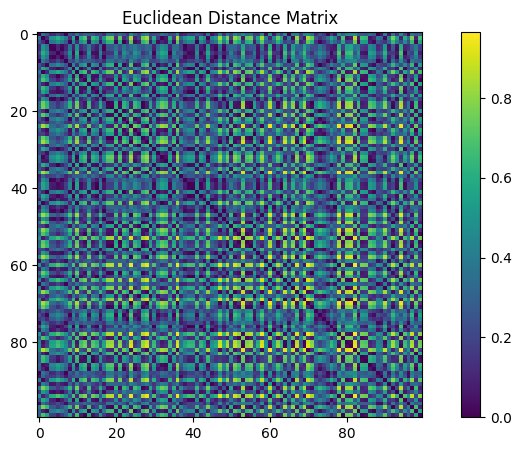

C:\Users\47915\AppData\Roaming\Python\Python311\site-packages\scipy\spatial\distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


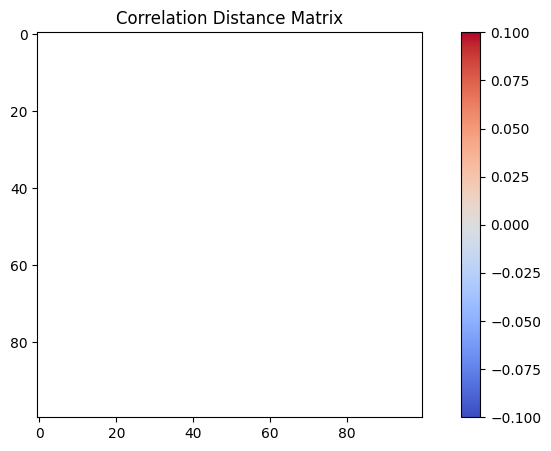

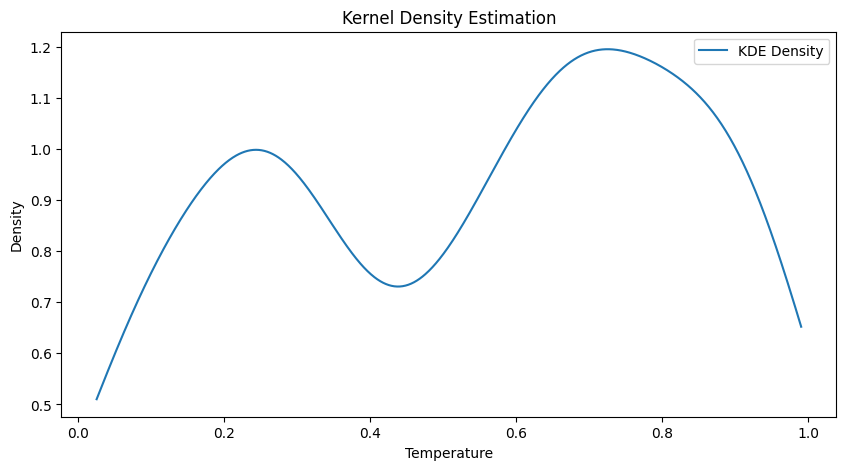

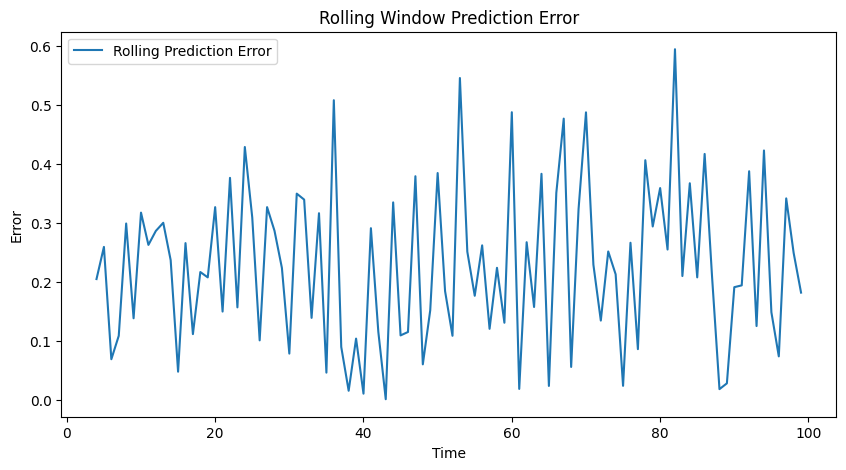

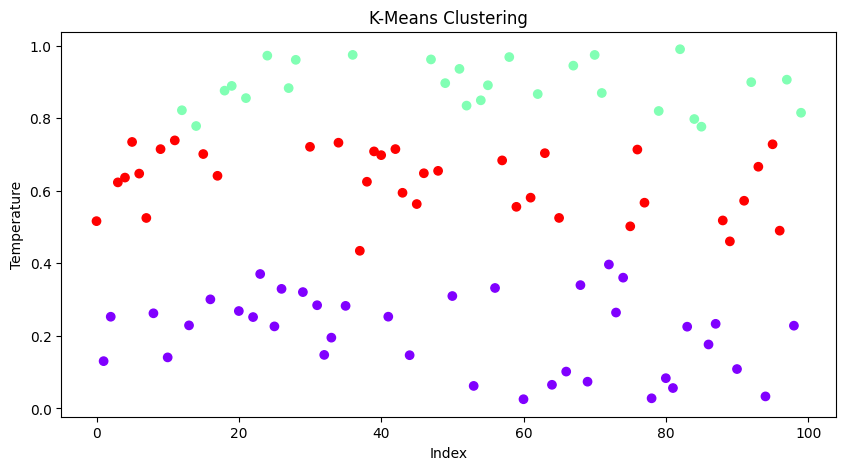

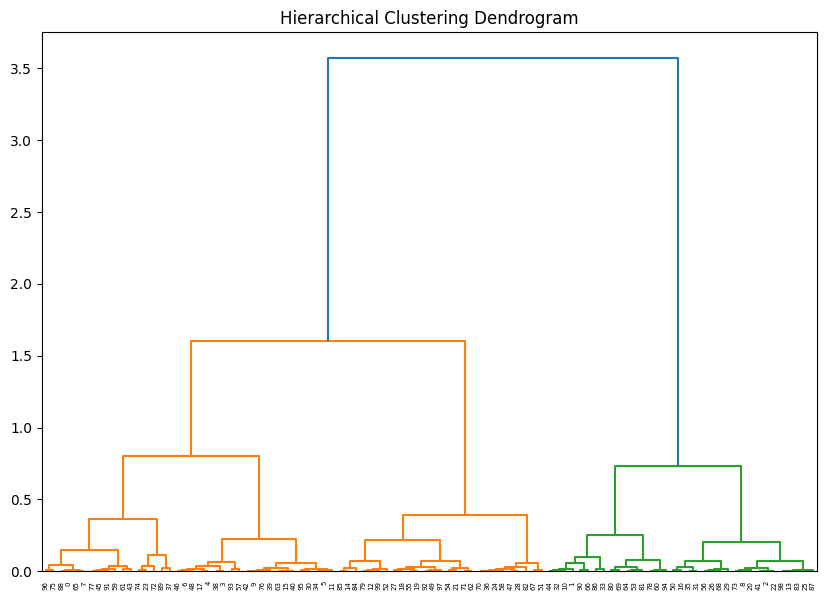

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import correlation

# Load your dataset here
# Assuming the data includes 'Actual_Temperature', 'XGBoost_Prediction', 'Max', and 'Min' columns
data = pd.DataFrame({  # Replace with actual data loading
    'Actual_Temperature': np.random.rand(100),
    'XGBoost_Prediction': np.random.rand(100),
    'Max': np.random.rand(100),
    'Min': np.random.rand(100)
})

# Extract univariate data (Actual Temperature for simplicity)
univariate_data = data['Actual_Temperature'].values.reshape(-1, 1)

# === Distance-Based Method 1: Euclidean Distance ===
def euclidean_distance_matrix(data):
    distances = euclidean_distances(data, data)
    plt.imshow(distances, cmap='viridis')
    plt.colorbar()
    plt.title("Euclidean Distance Matrix")
    plt.show()
    return distances

# Visualize Euclidean distances
euclidean_distances = euclidean_distance_matrix(univariate_data)

# === Distance-Based Method 2: Correlation Distance ===
def correlation_distance_matrix(data):
    distances = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            distances[i, j] = correlation(data[i], data[j])
    plt.imshow(distances, cmap='coolwarm')
    plt.colorbar()
    plt.title("Correlation Distance Matrix")
    plt.show()
    return distances

# Visualize Correlation distances
correlation_distances = correlation_distance_matrix(univariate_data)

# === Prediction-Based Method 1: Kernel Density Estimation ===
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(univariate_data)
x_plot = np.linspace(univariate_data.min(), univariate_data.max(), 1000)[:, None]
kde_scores = kde.score_samples(x_plot)

plt.plot(x_plot, np.exp(kde_scores), label='KDE Density')
plt.title("Kernel Density Estimation")
plt.xlabel("Temperature")
plt.ylabel("Density")
plt.legend()
plt.show()

# === Prediction-Based Method 2: Rolling Window Prediction Error ===
rolling_window_size = 5
rolling_mean = data['Actual_Temperature'].rolling(window=rolling_window_size).mean()
rolling_error = np.abs(data['Actual_Temperature'] - rolling_mean)

plt.plot(rolling_error, label='Rolling Prediction Error')
plt.title("Rolling Window Prediction Error")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.show()

# === Clustering-Based Method 1: K-Means Clustering ===
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(univariate_data)
data['Cluster'] = kmeans.labels_

plt.scatter(range(len(univariate_data)), univariate_data, c=kmeans.labels_, cmap='rainbow')
plt.title("K-Means Clustering")
plt.xlabel("Index")
plt.ylabel("Temperature")
plt.show()

# === Clustering-Based Method 2: Hierarchical Clustering ===
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(univariate_data, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()


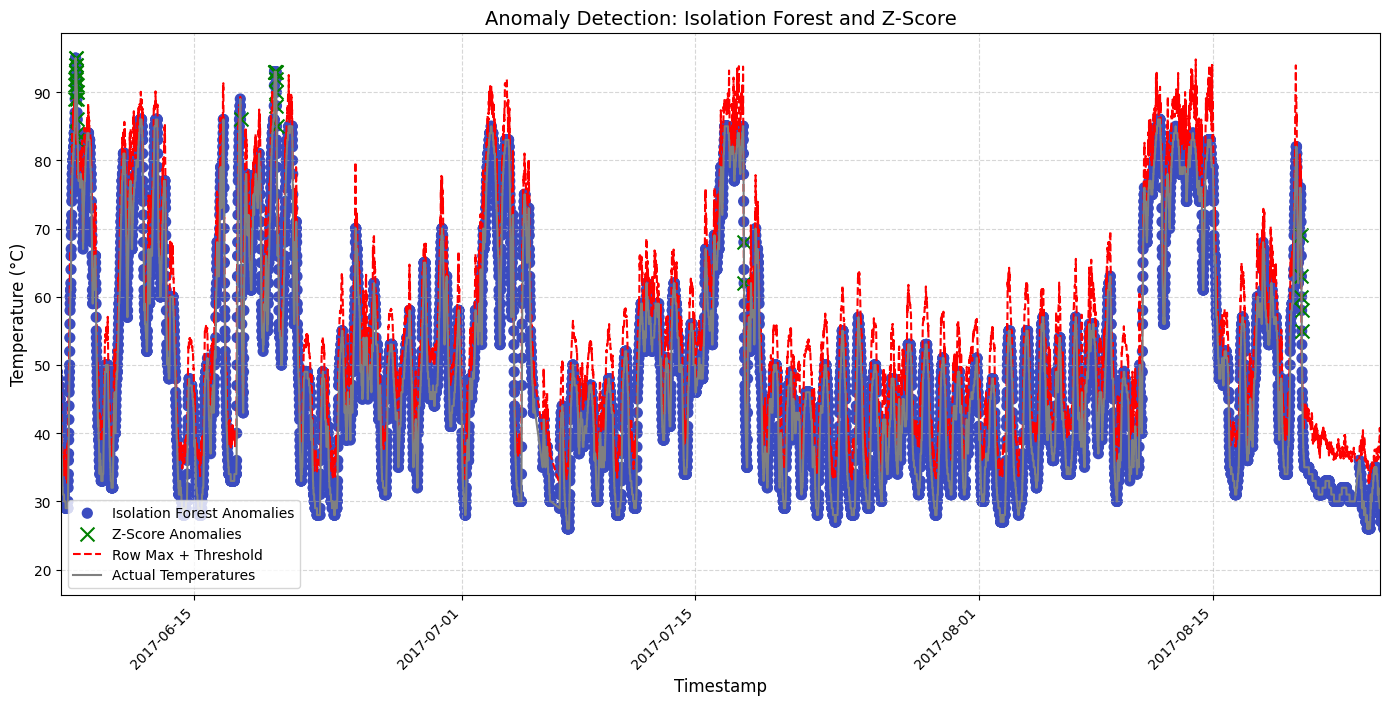

In [52]:
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
import matplotlib.pyplot as plt
import pandas as pd

threshold = 5

# Calculate the difference between `row_max + threshold` and the actual temperature
merged_df_filtered17_sorted['diff_max_actual'] = (
    merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'] - (merged_df_filtered17_sorted['row_max'] + threshold)
)

# Remove rows with NaN values
merged_df_filtered17_sorted = merged_df_filtered17_sorted.dropna(subset=['diff_max_actual'])

# === Isolation Forest Model ===
# Train the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.00001, random_state=42)
merged_df_filtered17_sorted['anomaly_isolation'] = isolation_forest.fit_predict(
    merged_df_filtered17_sorted[['diff_max_actual']]
)

# Convert Isolation Forest predictions to anomaly flags (1 for anomalies, 0 otherwise)
merged_df_filtered17_sorted['anomaly_isolation'] = (
    merged_df_filtered17_sorted['anomaly_isolation'] == -1
).astype(int)

# === Z-Score Model ===
# Calculate Z-scores for `diff_max_actual`
merged_df_filtered17_sorted['z_score'] = zscore(merged_df_filtered17_sorted['diff_max_actual'])

# Define an anomaly threshold for Z-score (e.g., absolute value > 3)
z_score_threshold = 5
merged_df_filtered17_sorted['anomaly_z_score'] = (
    merged_df_filtered17_sorted['z_score'].abs() > z_score_threshold
).astype(int)

# === Visualization ===
plt.figure(figsize=(14, 7))

# Scatter plot for Isolation Forest anomalies
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],
    c=merged_df_filtered17_sorted["anomaly_isolation"],
    cmap="coolwarm",
    label="Isolation Forest Anomalies",
    s=50
)

# Scatter plot for Z-score anomalies
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"][merged_df_filtered17_sorted["anomaly_z_score"] == 1],
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"][merged_df_filtered17_sorted["anomaly_z_score"] == 1],
    color='green',
    marker='x',
    s=100,
    label="Z-Score Anomalies"
)

# Add reference lines
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["row_max"] + threshold, 
    color='red', linestyle="--", label="Row Max + Threshold"
)

plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], 
    color='grey', label="Actual Temperatures"
)

# Configure plot
plt.title("Anomaly Detection: Isolation Forest and Z-Score", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (\u00b0C)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Apply x-axis limits
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-08-25'))

# Show plot
plt.show()


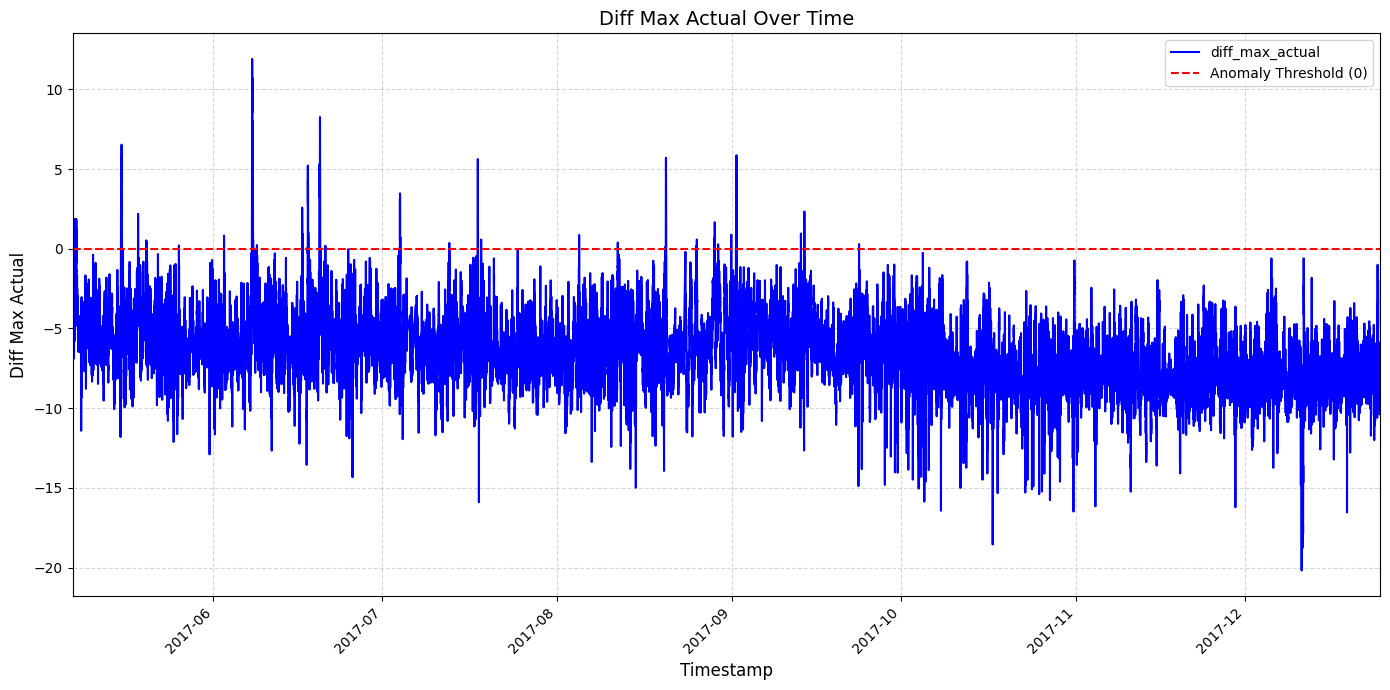

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

# === Visualization ===
plt.figure(figsize=(14, 7))

# Plot diff_max_actual with time
plt.plot(
    merged_df_filtered17_sorted["Timestamp"], 
    merged_df_filtered17_sorted["diff_max_actual"], 
    color='blue', label="diff_max_actual"
)

# Add reference line for anomaly threshold
plt.axhline(y=0, color='red', linestyle="--", label="Anomaly Threshold (0)")

# Configure plot
plt.title("Diff Max Actual Over Time", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Diff Max Actual", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Apply x-axis limits
plt.xlim(pd.to_datetime('2017-05-07'), pd.to_datetime('2017-12-25'))

# Show plot
plt.show()


In [ ]:
# Plot the feature with Timestamp on the x-axis and apply x-axis limits for better visibility
plt.figure(figsize=(14, 7))
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['diff_max_actual'], label='diff_max_actual', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Anomaly Threshold (0)')
plt.title('Feature Plot with Anomalies Over Time')
plt.xlabel('Timestamp')
plt.ylabel('diff_max_actual')
plt.legend()
plt.grid()

# Limiting the x-axis to show a specific portion of the data for clarity
plt.xlim(merged_df_filtered17_sorted['Timestamp'].iloc[0], 
         merged_df_filtered17_sorted['Timestamp'].iloc[100])  # Example: first 100 points
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [43]:
# Filter the data by date range
date_filtered_data = merged_df_filtered17_sorted[
    (merged_df_filtered17_sorted["Timestamp"] >= pd.to_datetime("2017-06-07").tz_localize("UTC")) &
    (merged_df_filtered17_sorted["Timestamp"] <= pd.to_datetime("2017-12-25").tz_localize("UTC"))
]
date_filtered_data.dropna(subset=["Gen_Bear_Temp_Avg", target_column, "Timestamp"])
# Use the smaller dataset for pairwise calculations
temperature_data = date_filtered_data["Gen_Bear_Temp_Avg"].values
actual = date_filtered_data["Gen_Bear_Temp_Avg"].values
predicted = date_filtered_data[target_column].values
timestamps = date_filtered_data["Timestamp"].values

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Combine actual and predicted into a single array for clustering
data_for_clustering = np.column_stack((predicted, actual))


# Remove rows with NaN values
data_for_clustering = data_for_clustering[~np.isnan(data_for_clustering).any(axis=1)]
# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust clusters if needed
date_filtered_data["Cluster"] = kmeans.fit_predict(data_for_clustering)

# Visualize clusters
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(kmeans.labels_):
    cluster_points = date_filtered_data[date_filtered_data["Cluster"] == cluster_id]
    plt.scatter(
        cluster_points[target_column],  # X: Predicted
        cluster_points["Gen_Bear_Temp_Avg"],  # Y: Actual
        label=f"Cluster {cluster_id}"
    )

plt.plot(predicted, predicted, color="red", linestyle="--", label="Prediction Reference Line")
plt.title("K-Means Clustering: Actual vs Predicted")
plt.xlabel("Predicted Temperature")
plt.ylabel("Actual Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Combine predicted and actual values into a DataFrame for cleaning
data_for_clustering = pd.DataFrame({
    "predicted": predicted,
    "actual": actual
})

# Drop rows with NaN values
data_for_clustering.dropna(inplace=True)

# Convert back to NumPy array
data_for_clustering = data_for_clustering.values

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10).fit(data_for_clustering)

# Assign cluster labels back to the original DataFrame
date_filtered_data = date_filtered_data.iloc[:len(data_for_clustering)].copy()  # Adjust length to match cleaned data
date_filtered_data["DBSCAN_Cluster"] = dbscan.labels_

# Visualize DBSCAN clusters
plt.figure(figsize=(12, 6))
for cluster_id in np.unique(dbscan.labels_):
    cluster_points = date_filtered_data[date_filtered_data["DBSCAN_Cluster"] == cluster_id]
    plt.scatter(
        cluster_points[target_column],  # X: Predicted
        cluster_points["Gen_Bear_Temp_Avg"],  # Y: Actual
        label=f"Cluster {cluster_id}" if cluster_id != -1 else "Outliers"
    )

plt.plot(predicted, predicted, color="red", linestyle="--", label="Prediction Reference Line")
plt.title("DBSCAN Clustering: Actual vs Predicted")
plt.xlabel("Predicted Temperature")
plt.ylabel("Actual Temperature")
plt.legend()
plt.grid()
plt.show()



In [ ]:
date_filtered_data['Rolling_Mean'] = date_filtered_data['Gen_Bear_Temp_Avg'].rolling(window=10).mean()
date_filtered_data['Rolling_Std'] = date_filtered_data['Gen_Bear_Temp_Avg'].rolling(window=10).std()
date_filtered_data['Anomaly'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - date_filtered_data['Rolling_Mean']) > 2 * date_filtered_data['Rolling_Std']


In [ ]:
from scipy.stats import zscore
date_filtered_data['Z_Score'] = zscore(date_filtered_data['Gen_Bear_Temp_Avg'])
date_filtered_data['Anomaly_Z_Score'] = abs(date_filtered_data['Z_Score']) > 2


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Z_Score']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Z_Score']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Z-Score")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.02)  # Adjust contamination rate as needed
date_filtered_data['Anomaly_IF'] = iso_forest.fit_predict(data_for_clustering)

# Convert -1 (anomalous) and 1 (normal) to boolean for easy filtering
date_filtered_data['Anomaly_IF'] = date_filtered_data['Anomaly_IF'] == -1


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_IF']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_IF']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Isolation Forest")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


Additional isolation forrest

In [ ]:
"""# Check for duplicate timestamps
if 'Turbine_ID' in date_filtered_data.columns:
    date_filtered_data.drop(columns=['Turbine_ID'], inplace=True)

# Drop duplicate timestamps, keeping the first occurrence
date_filtered_data = date_filtered_data[~date_filtered_data.index.duplicated(keep='first')]

# Alternatively, aggregate duplicate timestamps by averaging
date_filtered_data = date_filtered_data.groupby(date_filtered_data.index).mean()

"""



In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Reset index to ensure 'Timestamp' is available as a column
date_filtered_data.reset_index(inplace=True)

# Remove timezone information from the Timestamp column if any
date_filtered_data['Timestamp'] = date_filtered_data['Timestamp'].dt.tz_localize(None)

# Prepare the data for Prophet (ensure 'Timestamp' is now a column)
df_prophet = date_filtered_data[['Timestamp', 'Gen_Bear_Temp_Avg']].rename(columns={'Timestamp': 'ds', 'Gen_Bear_Temp_Avg': 'y'})

# Ensure the datetime column 'ds' has a proper frequency (set frequency to daily 'D')
df_prophet = df_prophet.set_index('ds').asfreq('D').reset_index()

# Fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Make future predictions (here we are just forecasting for the historical data)
future = model.make_future_dataframe(df_prophet, freq='D')
forecast = model.predict(future)

# Detect anomalies where actual values deviate significantly from the forecast
date_filtered_data['Anomaly_Prophet'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - forecast['yhat']) > 2 * (forecast['yhat_upper'] - forecast['yhat_lower'])

# Plot the actual data and forecast with anomalies
plt.figure(figsize=(14, 7))

# Plot the actual temperature
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], color='grey', alpha=0.8, label='Actual', linewidth=1.5)

# Plot the forecasted temperature (mean, upper, and lower bounds)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', color='blue', linewidth=1.5)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight anomalies (where actual temperature deviates significantly from forecast)
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Prophet']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Prophet']], color="red", label="Anomalies", s=80)

# Customize the plot
plt.title("Actual vs Forecasted Temperature with Anomalies Detected", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.seasonal import STL

# Ensure the Timestamp column is in datetime format
date_filtered_data['Timestamp'] = pd.to_datetime(date_filtered_data['Timestamp'])

# Set the frequency of the time series (daily in this case)
date_filtered_data.set_index('Timestamp', inplace=True)
date_filtered_data = date_filtered_data.asfreq('D')  # Set frequency to daily (change if needed)

# Perform STL decomposition
stl = STL(date_filtered_data['Gen_Bear_Temp_Avg'], seasonal=13)
result = stl.fit()

# Plot the decomposition
plt.figure(figsize=(12, 8))
result.plot()
plt.show()

# Use the residuals to detect anomalies
residuals = result.resid
date_filtered_data['Anomaly_STL'] = abs(residuals) > 2 * residuals.std()

# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data.index, date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data.index[date_filtered_data['Anomaly_STL']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_STL']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using STL Decomposition")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd

# Reset index to ensure 'Timestamp' is available as a column
date_filtered_data.reset_index(inplace=True)

# Remove timezone information from the Timestamp column if any
date_filtered_data['Timestamp'] = date_filtered_data['Timestamp'].dt.tz_localize(None)

# Prepare the data for Prophet (ensure 'Timestamp' is now a column)
df_prophet = date_filtered_data[['Timestamp', 'Gen_Bear_Temp_Avg']].rename(columns={'Timestamp': 'ds', 'Gen_Bear_Temp_Avg': 'y'})

# Ensure the datetime column 'ds' has a proper frequency (set frequency to daily 'D')
df_prophet = df_prophet.set_index('ds').asfreq('D').reset_index()

# Fit the Prophet model
model = Prophet()
model.fit(df_prophet)

# Make future predictions (here we are just forecasting for the historical data)
future = model.make_future_dataframe(df_prophet, freq='D')
forecast = model.predict(future)

# Detect anomalies where actual values deviate significantly from the forecast
date_filtered_data['Anomaly_Prophet'] = abs(date_filtered_data['Gen_Bear_Temp_Avg'] - forecast['yhat']) > 2 * (forecast['yhat_upper'] - forecast['yhat_lower'])

# Plot the actual data and forecast with anomalies
plt.figure(figsize=(14, 7))

# Plot the actual temperature
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], color='grey', alpha=0.8, label='Actual', linewidth=1.5)

# Plot the forecasted temperature (mean, upper, and lower bounds)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', color='blue', linewidth=1.5)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Uncertainty Interval')

# Highlight anomalies (where actual temperature deviates significantly from forecast)
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Prophet']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Prophet']], color="red", label="Anomalies", s=80)

# Customize the plot
plt.title("Actual vs Forecasted Temperature with Anomalies Detected", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(date_filtered_data['Timestamp'], date_filtered_data['Gen_Bear_Temp_Avg'], label="Actual Temperature")
plt.scatter(date_filtered_data['Timestamp'][date_filtered_data['Anomaly_Prophet']], date_filtered_data['Gen_Bear_Temp_Avg'][date_filtered_data['Anomaly_Prophet']], color="red", label="Anomalies")
plt.title("Anomalies Detected Using Prophet Model")
plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Drop rows with missing values in 'Gen_Bear_Temp_Avg'
merged_df_filtered17_sorted = merged_df_filtered17_sorted.dropna(subset=['Gen_Bear_Temp_Avg'])

# Now proceed with LOF model
from sklearn.neighbors import LocalOutlierFactor

# Define the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Fit the model and predict anomalies
X = merged_df_filtered17_sorted[['Gen_Bear_Temp_Avg']]  # Actual temperature data (or combine predicted and actual)
merged_df_filtered17_sorted['anomaly_lof'] = lof.fit_predict(X)
merged_df_filtered17_sorted['anomaly_lof'] = merged_df_filtered17_sorted['anomaly_lof'].apply(lambda x: 1 if x == -1 else 0)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by LOF
anomalies = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_lof'] == 1]
plt.scatter(anomalies['Timestamp'], anomalies['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (LOF)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Local Outlier Factor (LOF)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Compute Z-scores for Gen_Bear_Temp_Avg
merged_df_filtered17_sorted['z_score'] = (merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'] - merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'].mean()) / merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'].std()

# Define a threshold for anomaly detection
z_threshold = 3  # Example threshold: 3 standard deviations

# Flag anomalies where Z-score is above or below the threshold
merged_df_filtered17_sorted['anomaly_zscore'] = (np.abs(merged_df_filtered17_sorted['z_score']) > z_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Z-score
anomalies_zscore = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_zscore'] == 1]
plt.scatter(anomalies_zscore['Timestamp'], anomalies_zscore['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Z-score)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Z-Score Method", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


pd.to_datetime('2017-12-07'), pd.to_datetime('2017-12-15')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Ensure Timestamp is in datetime format
merged_df_filtered17_sorted['Timestamp'] = pd.to_datetime(merged_df_filtered17_sorted['Timestamp'])

# Filter the data between 2017-06-07 and 2017-06-25
start_date = '2017-06-07'
end_date = '2017-06-25'
filtered_data = merged_df_filtered17_sorted[(merged_df_filtered17_sorted['Timestamp'] >= start_date) & 
                                             (merged_df_filtered17_sorted['Timestamp'] <= end_date)]

# Define the autoencoder model
autoencoder = MLPRegressor(hidden_layer_sizes=(64, 32, 16, 32, 64), activation='relu', solver='adam', random_state=42)

# Use Gen_Bear_Temp_Avg as input and try to predict it
X = filtered_data[['Gen_Bear_Temp_Avg']].values
autoencoder.fit(X, X)  # Train the autoencoder

# Predict reconstructed values
reconstructed = autoencoder.predict(X)

# Calculate row-wise reconstruction error (Mean Squared Error for each sample)
reconstruction_error = np.mean((X - reconstructed) ** 2, axis=1)

# Define a threshold for reconstruction error (e.g., top 5% of reconstruction errors)
error_threshold = np.percentile(reconstruction_error, 99)  # top 5% errors are anomalies

# Flag anomalies based on reconstruction error
filtered_data['anomaly_autoencoder'] = (reconstruction_error > error_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(filtered_data['Timestamp'], filtered_data['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Autoencoder
anomalies_autoencoder = filtered_data[filtered_data['anomaly_autoencoder'] == 1]
plt.scatter(anomalies_autoencoder['Timestamp'], anomalies_autoencoder['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Autoencoder)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Autoencoder (June 7 - June 25, 2017)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Ensure Timestamp is in datetime format
merged_df_filtered17_sorted['Timestamp'] = pd.to_datetime(merged_df_filtered17_sorted['Timestamp'])

# Filter the data between 2017-06-07 and 2017-06-25
start_date = '2017-12-07'
end_date = '2017-12-15'
filtered_data = merged_df_filtered17_sorted[(merged_df_filtered17_sorted['Timestamp'] >= start_date) & 
                                             (merged_df_filtered17_sorted['Timestamp'] <= end_date)]

# Define the autoencoder model
autoencoder = MLPRegressor(hidden_layer_sizes=(64, 32, 16, 32, 64), activation='relu', solver='adam', random_state=42)

# Use Gen_Bear_Temp_Avg as input and try to predict it
X = filtered_data[['Gen_Bear_Temp_Avg']].values
autoencoder.fit(X, X)  # Train the autoencoder

# Predict reconstructed values
reconstructed = autoencoder.predict(X)

# Calculate row-wise reconstruction error (Mean Squared Error for each sample)
reconstruction_error = np.mean((X - reconstructed) ** 2, axis=1)

# Define a threshold for reconstruction error (e.g., top 5% of reconstruction errors)
error_threshold = np.percentile(reconstruction_error, 99)  # top 5% errors are anomalies

# Flag anomalies based on reconstruction error
filtered_data['anomaly_autoencoder'] = (reconstruction_error > error_threshold).astype(int)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(filtered_data['Timestamp'], filtered_data['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by Autoencoder
anomalies_autoencoder = filtered_data[filtered_data['anomaly_autoencoder'] == 1]
plt.scatter(anomalies_autoencoder['Timestamp'], anomalies_autoencoder['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (Autoencoder)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by Autoencoder (June 7 - June 25, 2017)", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.svm import OneClassSVM

# Initialize One-Class SVM
oc_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma="auto")

# Fit the model and predict anomalies
X = merged_df_filtered17_sorted[['Gen_Bear_Temp_Avg']]  # You can use a combination of actual and predicted values
merged_df_filtered17_sorted['anomaly_svm'] = oc_svm.fit_predict(X)
merged_df_filtered17_sorted['anomaly_svm'] = merged_df_filtered17_sorted['anomaly_svm'].apply(lambda x: 1 if x == -1 else 0)

# Plotting the results
plt.figure(figsize=(14, 7))

# Plot the actual values
plt.plot(merged_df_filtered17_sorted['Timestamp'], merged_df_filtered17_sorted['Gen_Bear_Temp_Avg'], label='Actual Temperature', color='gray', alpha=0.8)

# Highlight anomalies detected by One-Class SVM
anomalies_svm = merged_df_filtered17_sorted[merged_df_filtered17_sorted['anomaly_svm'] == 1]
plt.scatter(anomalies_svm['Timestamp'], anomalies_svm['Gen_Bear_Temp_Avg'], color='orange', label='Anomalies (SVM)', marker='o', s=80)

# Add labels and grid
plt.title("Anomalies Detected by One-Class SVM", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Gen_Bear_Temp_Avg", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
